In [1]:
# Import dependencies
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
from scipy.stats import norm
import statsmodels.api as sm
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Importing Dependencies for DB connection
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from config import config
import psycopg2

In [137]:
# Establish a connection to the database
conn = psycopg2.connect(
    host = config['host'],
    port = config['port'], 
    dbname = config['dbname'], 
    user = config['user'], 
    password = config['password'])

print("Postgres Connected")

Postgres Connected


In [7]:
# Import Data from AWS database
data= pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
data

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,408280,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,None
1,408283,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45385.0,None
2,653248,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,None
3,653251,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10375.0,None
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
...,...,...,...,...,...,...,...,...
7225,27254351,2021-04-01,Nunavut,101,"Total, all occupations",Full-time,515.0,None
7226,27263181,2021-04-01,Nunavut,1,"Business, finance and administration occupations","Type of work, all types",75.0,None
7227,27263184,2021-04-01,Nunavut,1,"Business, finance and administration occupations",Full-time,70.0,None
7228,27309524,2021-04-01,Nunavut,7,"Trades, transport and equipment operators and ...","Type of work, all types",160.0,None


In [8]:
#exporting data to csv for province level impute
data.to_csv('data.csv')

In [9]:
# slicing for 'Canada'
ts_data= data
ts_data= data.loc[data['geo']=='Canada',:]

ts_data.head()

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
5,1143187,2015-04-01,Canada,101,"Total, all occupations",Full-time,322450.0,None
6,1143190,2015-04-01,Canada,101,"Total, all occupations",Part-time,129475.0,None
7,1143302,2015-04-01,Canada,0,Management occupations,"Type of work, all types",24100.0,None
8,1143305,2015-04-01,Canada,0,Management occupations,Full-time,23030.0,None


In [10]:
# slicing for 'Total, all occupations' in NOC
ts_data= ts_data.loc[ts_data['noc_desc']=='Total, all occupations',:]

ts_data.head()

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
5,1143187,2015-04-01,Canada,101,"Total, all occupations",Full-time,322450.0,None
6,1143190,2015-04-01,Canada,101,"Total, all occupations",Part-time,129475.0,None
135,3429555,2015-10-01,Canada,101,"Total, all occupations",Full-time,230375.0,None
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,None


In [11]:
# slicing for 'Total, all occupations' in job_char
ts_data= ts_data.loc[ts_data['job_char']=='Type of work, all types',:]

ts_data.head()

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,None
608,3429552,2015-10-01,Canada,101,"Total, all occupations","Type of work, all types",358755.0,None
902,4572736,2016-01-01,Canada,101,"Total, all occupations","Type of work, all types",330215.0,None
1203,5715920,2016-04-01,Canada,101,"Total, all occupations","Type of work, all types",391190.0,None


In [12]:
df= ts_data
df

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,None
608,3429552,2015-10-01,Canada,101,"Total, all occupations","Type of work, all types",358755.0,None
902,4572736,2016-01-01,Canada,101,"Total, all occupations","Type of work, all types",330215.0,None
1203,5715920,2016-04-01,Canada,101,"Total, all occupations","Type of work, all types",391190.0,None
1527,6859104,2016-07-01,Canada,101,"Total, all occupations","Type of work, all types",404860.0,None
1840,8002288,2016-10-01,Canada,101,"Total, all occupations","Type of work, all types",381010.0,None
2154,9145472,2017-01-01,Canada,101,"Total, all occupations","Type of work, all types",387080.0,None
2468,10288656,2017-04-01,Canada,101,"Total, all occupations","Type of work, all types",459685.0,None
2787,11431840,2017-07-01,Canada,101,"Total, all occupations","Type of work, all types",467395.0,None


In [13]:
# remove unnecessary columns
df=df.loc[:, ['ref_date','total_vacancies']]
df

,ref_date,total_vacancies
4,2015-04-01,451925.0
301,2015-07-01,407865.0
608,2015-10-01,358755.0
902,2016-01-01,330215.0
1203,2016-04-01,391190.0
1527,2016-07-01,404860.0
1840,2016-10-01,381010.0
2154,2017-01-01,387080.0
2468,2017-04-01,459685.0
2787,2017-07-01,467395.0


In [14]:
df.shape

(23, 2)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 4 to 6921
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ref_date         23 non-null     object 
 1   total_vacancies  23 non-null     float64
dtypes: float64(1), object(1)
memory usage: 552.0+ bytes


In [16]:
# impute missing data for Q2 & Q3 2020

missing_data = pd.DataFrame({'ref_date': ['2020-04-01','2020-07-01'],
                    'total_vacancies' : [544151.77,531932.19]})

df = pd.concat([df, missing_data], ignore_index = True, axis = 0)

df.tail()

,ref_date,total_vacancies
20,2020-10-01,560215.00
21,2021-01-01,553480.00
22,2021-04-01,731905.00
23,2020-04-01,544151.77
24,2020-07-01,531932.19


In [17]:
df.shape

(25, 2)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ref_date         25 non-null     object 
 1   total_vacancies  25 non-null     float64
dtypes: float64(1), object(1)
memory usage: 528.0+ bytes


In [19]:
#  convert the REF_DATE column into a datetime object
df['ref_date'] = pd.to_datetime(df['ref_date'], format='%Y-%m')

In [20]:
df.sort_values(by='ref_date', ascending=True, inplace=True)
df.tail()

,ref_date,total_vacancies
23,2020-04-01,544151.77
24,2020-07-01,531932.19
20,2020-10-01,560215.00
21,2021-01-01,553480.00
22,2021-04-01,731905.00


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 0 to 22
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ref_date         25 non-null     datetime64[ns]
 1   total_vacancies  25 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 600.0 bytes


In [22]:
df.set_index('ref_date', inplace=True)
print(df.shape)

(25, 1)


In [23]:
df

,total_vacancies
ref_date,
2015-04-01,451925.00
2015-07-01,407865.00
2015-10-01,358755.00
2016-01-01,330215.00
2016-04-01,391190.00
2016-07-01,404860.00
2016-10-01,381010.00
2017-01-01,387080.00
2017-04-01,459685.00


## Time series Analysis 

In [24]:
#visualize the time series data

(array([16071., 16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

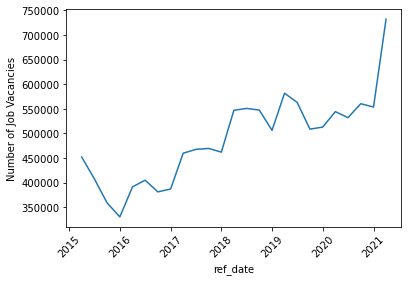

In [25]:
sns.lineplot(data= df, x='ref_date', y= 'total_vacancies')
plt.ylabel('Number of Job Vacancies')
plt.xticks(rotation=45)

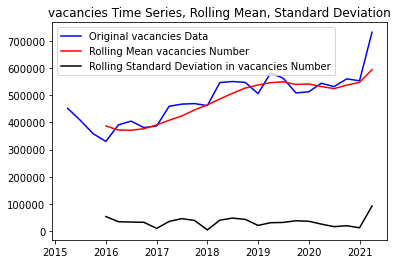

In [26]:
'''check for stationary
A stationary time series will not have any trends or seasonal patterns
We will use the Dickey Fuller test to check for stationarity in our data '''

rolling_mean = df.rolling(4).mean()
rolling_std = df.rolling(4).std()

#First, let’s make a Matplotlib plot of our time series
plt.plot(df, color="blue",label="Original vacancies Data")
# then the rolling mean
plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
#And finally, the rolling standard deviation:
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
#Let’s then add a title:
plt.title("vacancies Time Series, Rolling Mean, Standard Deviation")
#And a legend:
plt.legend(loc="best")

In [27]:
#We will use the Dickey Fuller test to check for stationarity in our data
from statsmodels.tsa.stattools import adfuller
df_test=df.iloc[:,0].values
adft = adfuller(df_test,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0   2.347944              Test Statistics
1   0.998984                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)


our data is not stationary as p value is higher than 0.05

In [28]:
# Checking for autocorrelation in time series data
# This is a measure of how correlated time series data is at a given point in time with past values
autocorrelation_lag1 = df['total_vacancies'].autocorr(lag=1)
print("One Quarter Lag: ", autocorrelation_lag1)

autocorrelation_lag2 = df['total_vacancies'].autocorr(lag=2)
print("Two Quaretrs Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = df['total_vacancies'].autocorr(lag=3)
print("Three Quaretrs Lag: ", autocorrelation_lag3)

autocorrelation_lag4 = df['total_vacancies'].autocorr(lag=4)
print("Four Quaretrs Lag: ", autocorrelation_lag4)

One Quarter Lag:  0.8145162959523269
Two Quaretrs Lag:  0.7294501466461943
Three Quaretrs Lag:  0.685410879335562
Four Quaretrs Lag:  0.7399548793483853


the data is autocorrelated

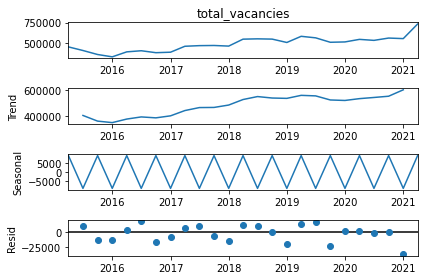

In [29]:
#Check for Trend decomposition is another useful way to visualize the trends in time series data
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['total_vacancies'],model='additive', period=2)
decompose.plot()
plt.show()

From this plot, we can clearly see the increasing trend in number of vacancies and the seasonality patterns in the rise and fall in values each year.

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


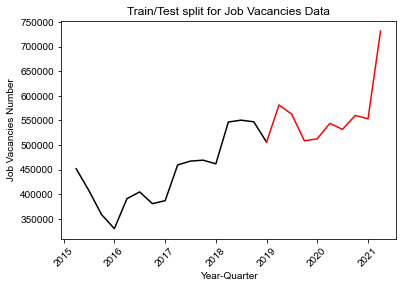

In [30]:
# Forescasting
df['ref_date']=df.index
train = df[df['ref_date'] < "2019-04-01"]
train['train'] = train['total_vacancies']
del train['ref_date']
del train['total_vacancies']

test = df[df['ref_date'] >= "2019-04-01"]
del test['ref_date']
test['test'] = test['total_vacancies']
del test['total_vacancies']

plt.plot(train, color = "black")
plt.plot(pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test]), color = "red")
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
sns.set()
plt.show()

In [31]:
# code to connect train and split data for the plot above
pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test])

,test
ref_date,
2019-01-01,506140.00
2019-04-01,581595.00
2019-07-01,562910.00
2019-10-01,508590.00
2020-01-01,512760.00
2020-04-01,544151.77
2020-07-01,531932.19
2020-10-01,560215.00
2021-01-01,553480.00


## SARIMAX

source: https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

In [32]:
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

## Re-trian SARIMAX model with all data available

In [33]:
# Dataset
data = df
data.index = data.ref_date
# Set the frequency
data.index.freq="QS-OCT"

# Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
mod = sm.tsa.statespace.SARIMAX(train, trend='t', order=(1,0,1),seasonal_order=(1, 1, 1, 2))
res = mod.fit(disp=False)
print(res.summary())

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                     
Dep. Variable:                             train   No. Observations:                   16
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 2)   Log Likelihood                -173.868
Date:                           Sun, 28 Nov 2021   AIC                            359.736
Time:                                   12:08:23   BIC                            363.571
Sample:                               04-01-2015   HQIC                           359.381
                                    - 01-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -977.1508      0.000  -2.77e+06      0.000    -977.152    -977.150
ar.L1         -0.6853      0.079     -8.722

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [34]:
# forecast values for test data
forecast = res.predict(test.index[0],test.index[-1], dynamic=True)
forecast = pd.DataFrame(forecast.values,index = test.index,columns=['predicted_vacancies'])
forecast.head()

,predicted_vacancies
ref_date,
2019-04-01,587407.392035
2019-07-01,549985.454825
2019-10-01,535895.200785
2020-01-01,495415.010295
2020-04-01,575212.485279


In [35]:
# create dataframe for results
output = test.merge(forecast, how='inner', left_index=True, right_index=True)
output.head()

,test,predicted_vacancies
ref_date,,
2019-04-01,581595.00,587407.392035
2019-07-01,562910.00,549985.454825
2019-10-01,508590.00,535895.200785
2020-01-01,512760.00,495415.010295
2020-04-01,544151.77,575212.485279


In [36]:
#Evaluating SARIMA model

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,explained_variance_score,r2_score

evs = explained_variance_score(output.test,output.predicted_vacancies,multioutput='uniform_average')
print(f'Explained Variance Score : {evs}')
mse = mean_squared_error(output.test,output.predicted_vacancies, squared=False)
print(f'Mean Square Error : {mse}')
mape = mean_absolute_percentage_error(output.test,output.predicted_vacancies, multioutput='uniform_average')
print(f'Mean Absolute Percentage Error : {mape}')
rsqr =r2_score(output.test,output.predicted_vacancies,multioutput='uniform_average')
print(f'Coefficient of determination Training (R^2) : {rsqr}')

Explained Variance Score : 0.11631624500106941
Mean Square Error : 64963.2108702779
Mean Absolute Percentage Error : 0.06869572421393597
Coefficient of determination Training (R^2) : -0.06299270869868479


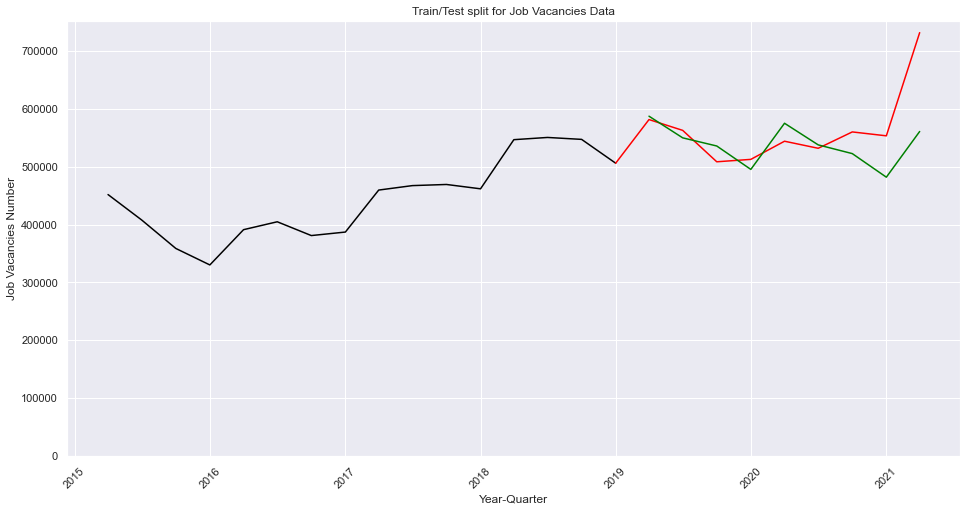

In [37]:
#visualize results
plt.plot(train, color = "black")
plt.plot(pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test]), color = "red")
plt.plot(forecast['predicted_vacancies'],color= 'green')
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
sns.set()
plt.show()

In [38]:
# rename columns to prepare for later append
output.columns=['total_vacancies','predicted_vacancies']
output.head()

,total_vacancies,predicted_vacancies
ref_date,,
2019-04-01,581595.00,587407.392035
2019-07-01,562910.00,549985.454825
2019-10-01,508590.00,535895.200785
2020-01-01,512760.00,495415.010295
2020-04-01,544151.77,575212.485279


In [39]:
# check model accuaracy with actual values from statCan
Actual=[560215,553480,731905]
predict_quarters=['2020-10-01','2021-01-01','2021-04-01']

forecast_data=[]
counter=0
for i in predict_quarters:
    forecast_test = res.predict(i)
    forecast_data.append(forecast_test)
    counter +=1
    
forecast_data

[2020-10-01    522737.441305
 Freq: QS-OCT, dtype: float64,
 2021-01-01    481961.986259
 Freq: QS-OCT, dtype: float64,
 2021-04-01    560978.298278
 Freq: QS-OCT, dtype: float64]

In [40]:
forecast_data[2].index # list of dataframes

DatetimeIndex(['2021-04-01'], dtype='datetime64[ns]', freq='QS-OCT')

In [41]:
#keep only forecast numbers
[int(f.values[0]) for f in forecast_data]

[522737, 481961, 560978]

In [42]:
# create results dataframe
forecast_df= pd.DataFrame({'Predicted Value':[int(f.values[0]) for f in forecast_data], 'Actual Value': Actual}, index=predict_quarters)
forecast_df.head()

,Predicted Value,Actual Value
2020-10-01,522737,560215
2021-01-01,481961,553480
2021-04-01,560978,731905


In [43]:
# generate predictions from Q2 2021-Q2 2025 for DB
actual_all = ['NAN','NAN',\
             'NAN','NAN','NAN','NAN',\
              'NAN','NAN','NAN','NAN',\
              'NAN','NAN','NAN','NAN',\
              'NAN','NAN','NAN','NAN']
future_predictions= ['2021-07-01','2021-10-01',\
                     '2022-01-01','2022-04-01','2022-07-01','2022-10-01',\
                     '2023-01-01','2023-04-01','2023-07-01','2023-10-01',\
                    '2024-01-01','2024-04-01','2024-07-01','2024-10-01',\
                     '2025-01-01','2025-04-01','2025-07-01','2025-10-01']

forecast_all=[]

counter=0
for i in future_predictions:
    forecasts = res.predict(i)
    forecast_all.append(forecasts)
    counter +=1
    
forecast_all

[2021-07-01    523135.306389
 Freq: QS-OCT, dtype: float64,
 2021-10-01    507391.855414
 Freq: QS-OCT, dtype: float64,
 2022-01-01    466099.489547
 Freq: QS-OCT, dtype: float64,
 2022-04-01    544486.528351
 Freq: QS-OCT, dtype: float64,
 2022-07-01    506092.930312
 Freq: QS-OCT, dtype: float64,
 2022-10-01    489755.927449
 Freq: QS-OCT, dtype: float64,
 2023-01-01    447897.771692
 Freq: QS-OCT, dtype: float64,
 2023-04-01    525689.033803
 Freq: QS-OCT, dtype: float64,
 2023-07-01    486721.875884
 Freq: QS-OCT, dtype: float64,
 2023-10-01    469807.04991
 Freq: QS-OCT, dtype: float64,
 2024-01-01    427372.325071
 Freq: QS-OCT, dtype: float64,
 2024-04-01    504575.198075
 Freq: QS-OCT, dtype: float64,
 2024-07-01    465029.418378
 Freq: QS-OCT, dtype: float64,
 2024-10-01    447540.237227
 Freq: QS-OCT, dtype: float64,
 2025-01-01    404526.566178
 Freq: QS-OCT, dtype: float64,
 2025-04-01    481142.679928
 Freq: QS-OCT, dtype: float64,
 2025-07-01    441017.162188
 Freq: QS-OC

In [44]:
#keep only forecast numbers
[int(f.values[0]) for f in forecast_all]

[523135,
 507391,
 466099,
 544486,
 506092,
 489755,
 447897,
 525689,
 486721,
 469807,
 427372,
 504575,
 465029,
 447540,
 404526,
 481142,
 441017,
 422954]

In [45]:
# create results dataframe
forecast_all_df= pd.DataFrame({'predicted_vacancies':[int(f.values[0]) for f in forecast_all], 'total_vacancies': actual_all}, index=future_predictions)
forecast_all_df= pd.DataFrame(forecast_all_df,columns=['total_vacancies','predicted_vacancies'])
forecast_all_df.head()                      

,total_vacancies,predicted_vacancies
2021-07-01,NAN,523135
2021-10-01,NAN,507391
2022-01-01,NAN,466099
2022-04-01,NAN,544486
2022-07-01,NAN,506092


In [46]:
#create model output
model_output = output.append(forecast_all_df)
model_output

,total_vacancies,predicted_vacancies
2019-04-01 00:00:00,581595.0,587407.392035
2019-07-01 00:00:00,562910.0,549985.454825
2019-10-01 00:00:00,508590.0,535895.200785
2020-01-01 00:00:00,512760.0,495415.010295
2020-04-01 00:00:00,544151.77,575212.485279
2020-07-01 00:00:00,531932.19,537816.013763
2020-10-01 00:00:00,560215.0,522737.441305
2021-01-01 00:00:00,553480.0,481961.986259
2021-04-01 00:00:00,731905.0,560978.298278
2021-07-01,NAN,523135.000000


In [47]:
#fix the index
ref_date= model_output.index.to_list()

In [48]:
model_output['ref_date']=ref_date
model_output

,total_vacancies,predicted_vacancies,ref_date
2019-04-01 00:00:00,581595.0,587407.392035,2019-04-01
2019-07-01 00:00:00,562910.0,549985.454825,2019-07-01
2019-10-01 00:00:00,508590.0,535895.200785,2019-10-01
2020-01-01 00:00:00,512760.0,495415.010295,2020-01-01
2020-04-01 00:00:00,544151.77,575212.485279,2020-04-01
2020-07-01 00:00:00,531932.19,537816.013763,2020-07-01
2020-10-01 00:00:00,560215.0,522737.441305,2020-10-01
2021-01-01 00:00:00,553480.0,481961.986259,2021-01-01
2021-04-01 00:00:00,731905.0,560978.298278,2021-04-01
2021-07-01,NAN,523135.000000,2021-07-01


In [49]:
model_output.set_index('ref_date', inplace=True)
model_output

,total_vacancies,predicted_vacancies
ref_date,,
2019-04-01,581595.0,587407.392035
2019-07-01,562910.0,549985.454825
2019-10-01,508590.0,535895.200785
2020-01-01,512760.0,495415.010295
2020-04-01,544151.77,575212.485279
2020-07-01,531932.19,537816.013763
2020-10-01,560215.0,522737.441305
2021-01-01,553480.0,481961.986259
2021-04-01,731905.0,560978.298278


In [58]:
model_output['ref_date']=['2019-04-01','2019-07-01','2019-10-01','2020-01-01','2020-04-01','2020-07-01','2020-10-01',\
                          '2021-01-01','2021-04-01','2021-07-01','2021-10-01',\
                          '2022-01-01','2022-04-01','2022-07-01','2022-10-01',\
                          '2023-01-01','2023-04-01','2023-07-01','2023-10-01',\
                          '2024-01-01','2024-04-01','2024-07-01','2024-10-01',\
                          '2025-01-01','2025-04-01','2025-07-01','2025-10-01']
model_output['geo']='Canada'
model_output['noc_code']=101
model_output['noc_desc']='Total, all occupations'
model_output['job_char']='Type of work, all types'
model_output=model_output[['ref_date','geo','noc_code','noc_desc','job_char','total_vacancies','predicted_vacancies']]
model_output

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
ref_date,,,,,,,
2019-04-01,2019-04-01,Canada,101,"Total, all occupations","Type of work, all types",581595.0,587407.392035
2019-07-01,2019-07-01,Canada,101,"Total, all occupations","Type of work, all types",562910.0,549985.454825
2019-10-01,2019-10-01,Canada,101,"Total, all occupations","Type of work, all types",508590.0,535895.200785
2020-01-01,2020-01-01,Canada,101,"Total, all occupations","Type of work, all types",512760.0,495415.010295
2020-04-01,2020-04-01,Canada,101,"Total, all occupations","Type of work, all types",544151.77,575212.485279
2020-07-01,2020-07-01,Canada,101,"Total, all occupations","Type of work, all types",531932.19,537816.013763
2020-10-01,2020-10-01,Canada,101,"Total, all occupations","Type of work, all types",560215.0,522737.441305
2021-01-01,2021-01-01,Canada,101,"Total, all occupations","Type of work, all types",553480.0,481961.986259
2021-04-01,2021-04-01,Canada,101,"Total, all occupations","Type of work, all types",731905.0,560978.298278


In [61]:
engine = create_engine(f"postgresql://{config['user']}:{config['password']}@{config['host']}:5432/{config['dbname']}")
conn=engine.connect()
model_output.to_sql(name='TSmodel_output_Canada', con=conn, index=False)

In [62]:
output_test= pd.read_sql_query('SELECT * FROM "TSmodel_output_Canada"', con=conn, index_col='ref_date')
output_test

,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
ref_date,,,,,,
2019-04-01,Canada,101,"Total, all occupations","Type of work, all types",581595.0,587407.392035
2019-07-01,Canada,101,"Total, all occupations","Type of work, all types",562910.0,549985.454825
2019-10-01,Canada,101,"Total, all occupations","Type of work, all types",508590.0,535895.200785
2020-01-01,Canada,101,"Total, all occupations","Type of work, all types",512760.0,495415.010295
2020-04-01,Canada,101,"Total, all occupations","Type of work, all types",544151.77,575212.485279
2020-07-01,Canada,101,"Total, all occupations","Type of work, all types",531932.19,537816.013763
2020-10-01,Canada,101,"Total, all occupations","Type of work, all types",560215.0,522737.441305
2021-01-01,Canada,101,"Total, all occupations","Type of work, all types",553480.0,481961.986259
2021-04-01,Canada,101,"Total, all occupations","Type of work, all types",731905.0,560978.298278


In [63]:
conn

In [64]:
ts_data.tail()

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
5681,21529858,2019-10-01,Canada,101,"Total, all occupations","Type of work, all types",508590.0,None
6006,22649088,2020-01-01,Canada,101,"Total, all occupations","Type of work, all types",512760.0,None
6311,23821336,2020-10-01,Canada,101,"Total, all occupations","Type of work, all types",560215.0,None
6616,24993584,2021-01-01,Canada,101,"Total, all occupations","Type of work, all types",553480.0,None
6921,26165832,2021-04-01,Canada,101,"Total, all occupations","Type of work, all types",731905.0,None


In [127]:
# Function to apply timeseries model on province level
def province_vac (province):
    import warnings
    warnings.filterwarnings("ignore")
    
    # Import Data from AWS database
    df_prov = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
    
    #preprocess data for province
    df_prov= df_prov.loc[df_prov['geo']!= 'Canada',:]
    df_prov= df_prov.loc[df_prov['noc_desc']== 'Total, all occupations',:]
    df_prov= df_prov.loc[df_prov['job_char']== 'Type of work, all types',:]
    df_prov=df_prov.loc[:,['ref_date','geo','total_vacancies']]
    
    #Impute missing data
    missing_prov = {'ref_date' : ["2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01"],\
                'geo': ['Newfoundland and Labrador',
                        'Prince Edward Island',
                        'Nova Scotia',
                        'New Brunswick',
                        'Quebec',
                        'Ontario',
                        'Manitoba',
                        'Saskatchewan',
                        'Alberta',
                        'British Columbia',
                        'Yukon',
                        'Northwest Territories',
                        'Nunavut',
                        'Newfoundland and Labrador',
                        'Prince Edward Island',
                        'Nova Scotia',
                        'New Brunswick',
                        'Quebec',
                        'Ontario',
                        'Manitoba',
                        'Saskatchewan',
                        'Alberta',
                        'British Columbia',
                        'Yukon',
                        'Northwest Territories',
                        'Nunavut'],
                'total_vacancies': [4812.289578,2920.42319,13010.0707,11839.29879,132545.1835,192941.8119,16933.82862,\
                                    11583.66541,48273.51128,100171.1173,1113.305809,462.2260516,431.3007519,4842.348548,\
                                    2614.571134,13056.11507,11312.29248,132064.3476,195694.8163,17184.18819,11542.33083,\
                                    48197.02256,102454.3798,1082.704106,456.2962351,437.6015038]
               }

        
         
    missing_prov_df= pd.DataFrame.from_dict(missing_prov)
    # add intrapolated values  
    df_prov= pd.concat([df_prov, missing_prov_df], ignore_index = True, axis = 0)
    
    #  convert the REF_DATE column into a datetime object
    df_prov['ref_date'] = pd.to_datetime(df_prov['ref_date'], format='%Y-%m')
    # sort by date
    df_prov.sort_values(by='ref_date', inplace=True )
    
    #select province data 
    prov_vac= df_prov.loc[df_prov['geo']== str(province),:] 
    # drop all unnecessary columns
    prov_vac = prov_vac.loc[:,['ref_date','total_vacancies']]
    #set index
    prov_vac.set_index('ref_date', inplace=True)
    
    #start Q12015 onwards
    prov_vac= prov_vac.loc['2015-04-01':'2021-04-01']
    
    # rename columns
    prov_vac.rename(columns={'total_vacancies':f'{province}_total_vacancies'}, inplace=True)
    #visualize the time series data
    sns.lineplot(data= prov_vac, x='ref_date', y= f'{province}_total_vacancies')
    plt.ylabel('Number of Job Vacancies')
    plt.xticks(rotation=45)
    
    #check for stationary using the Dickey Fuller test to check for stationarity in our data
    rolling_mean = prov_vac.rolling(4).mean()
    rolling_std = prov_vac.rolling(4).std()
    #First, make a Matplotlib plot of our time series
    plt.plot(prov_vac, color="blue",label="Original vacancies Data")
    # then the rolling mean
    plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
    #And finally, the rolling standard deviation:
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
    #add a title:
    plt.title(f'{province} vacancies Time Series, Rolling Mean, Standard Deviation')
    #And a legend:
    plt.legend(loc="best")
    #use the Dickey Fuller test to check for stationarity in our data
    from statsmodels.tsa.stattools import adfuller
    prov_vac_test=prov_vac.iloc[:,0].values
    adft_prov = adfuller(prov_vac_test,autolag="AIC")
    output_prov_df = pd.DataFrame({"Values":[adft_prov[0],adft_prov[1],adft_prov[2],adft_prov[3], adft_prov[4]['1%'], adft_prov[4]['5%'], adft_prov[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print('Stationary Test Results')
    print(output_prov_df)
    
    # Checking for autocorrelation in time series data
    print('Autocorrelation Results')
    autocorrelation_lag1_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=1)
    print("One Quarter Lag: ", autocorrelation_lag1_prov)
    autocorrelation_lag2_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=2)
    print("Two Quaretrs Lag: ", autocorrelation_lag2_prov)
    autocorrelation_lag3_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=3)
    print("Three Quaretrs Lag: ", autocorrelation_lag3_prov)
    autocorrelation_lag4_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=4)
    print("Four Quaretrs Lag: ", autocorrelation_lag4_prov)
    
    #Check for Trend decomposition to visualize the trends in time series data
    from statsmodels.tsa.seasonal import seasonal_decompose
    decompose_prov = seasonal_decompose(prov_vac[f'{province}_total_vacancies'],model='additive', period=4)
    decompose_prov.plot()
    print('Trend Decomposition Visualization')
    plt.show()
    
    # Forescasting
    prov_vac['ref_date']=prov_vac.index
    train_prov = prov_vac[prov_vac['ref_date'] < "2019-04-01"]
    train_prov[f'train_{province}'] = train_prov[f'{province}_total_vacancies']
    del train_prov['ref_date']
    del train_prov[f'{province}_total_vacancies']
    
    test_prov = prov_vac[prov_vac['ref_date'] >= "2019-04-01"]
    del test_prov['ref_date']
    test_prov[f'test_{province}'] = test_prov[f'{province}_total_vacancies']
    del test_prov[f'{province}_total_vacancies']

    # Register converters to avoid warnings
    pd.plotting.register_matplotlib_converters()
    plt.rc("figure", figsize=(16,8))
    plt.rc("font", size=14)
    
    # Dataset
    data_prov = prov_vac
    data_prov.index = data_prov.ref_date
    # Set the frequency
    data_prov.index.freq="QS-OCT"

    # Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
    mod_prov = sm.tsa.statespace.SARIMAX(train_prov, trend='t', order=(0,1,0),seasonal_order=(1, 1, 1, 4))
    res_prov = mod_prov.fit(disp=False)
    print(res_prov.summary())
    
    # produce forecast results
    forecast_prov = res_prov.predict(test_prov.index[0],test_prov.index[-1], dynamic=True)
    forecast_prov = pd.DataFrame(forecast_prov.values,index = test_prov.index,columns=[f'Prediction_{province}'])
    output_prov = test_prov.merge(forecast_prov, how='inner', left_index=True, right_index=True)
    print('Forecast Results')
    
    
    #plot results
    plt.plot(train_prov, color = "black")
    plt.plot(test_prov, color = "red")
    plt.plot(forecast_prov[f'Prediction_{province}'],color= 'green')
    plt.title(f"Train/Test/Forecast split for {province} Job Vacancies Data")
    plt.ylabel("Job Vacancies Number")
    plt.xlabel('Year-Quarter')
    plt.xticks(rotation=45)
    plt.ylim(ymin=0)
    sns.set()
    plt.show()
    
    from sklearn.metrics import mean_squared_error

    rms_prov = mean_squared_error(output_prov[f'test_{province}'],output_prov[f'Prediction_{province}'], squared=False)
                                  
    print(f'RMSE is {rms_prov}')
    
    res_prov.save(f'TSmodel_{province}.pkl')
    return output_prov
    
  

Stationary Test Results
      Values                       Metric
0  -0.076956              Test Statistics
1   0.951686                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6697224585822977
Two Quaretrs Lag:  0.6758661167080275
Three Quaretrs Lag:  0.5121048632270008
Four Quaretrs Lag:  0.5183513350392196
Trend Decomposition Visualization


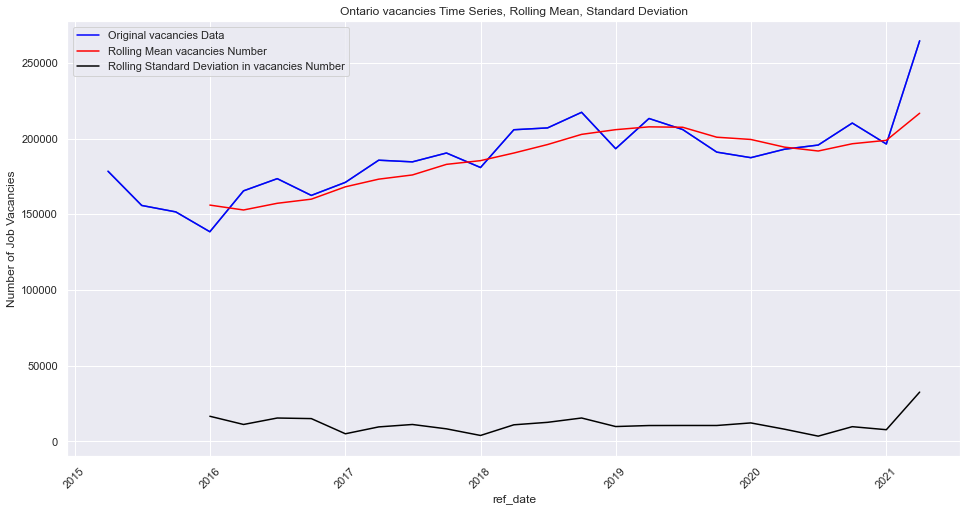

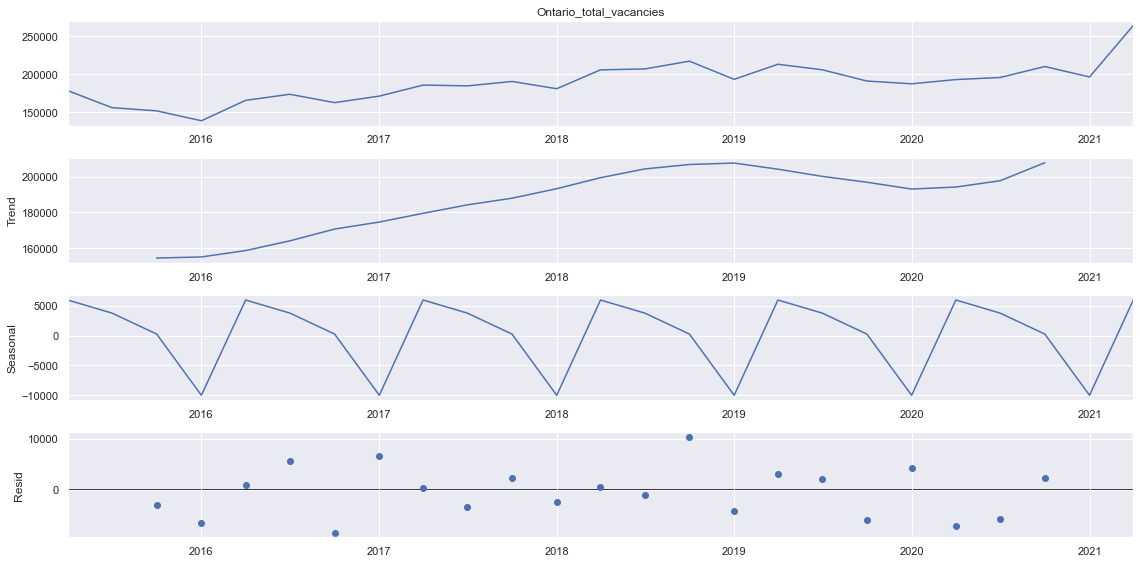

                                      SARIMAX Results                                      
Dep. Variable:                       train_Ontario   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -121.401
Date:                             Sun, 28 Nov 2021   AIC                            250.802
Time:                                     13:08:20   BIC                            252.394
Sample:                                 04-01-2015   HQIC                           249.799
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        190.4937    984.238      0.194      0.847   -1738.578    2119.565
ar.S.L4       -0.9466      

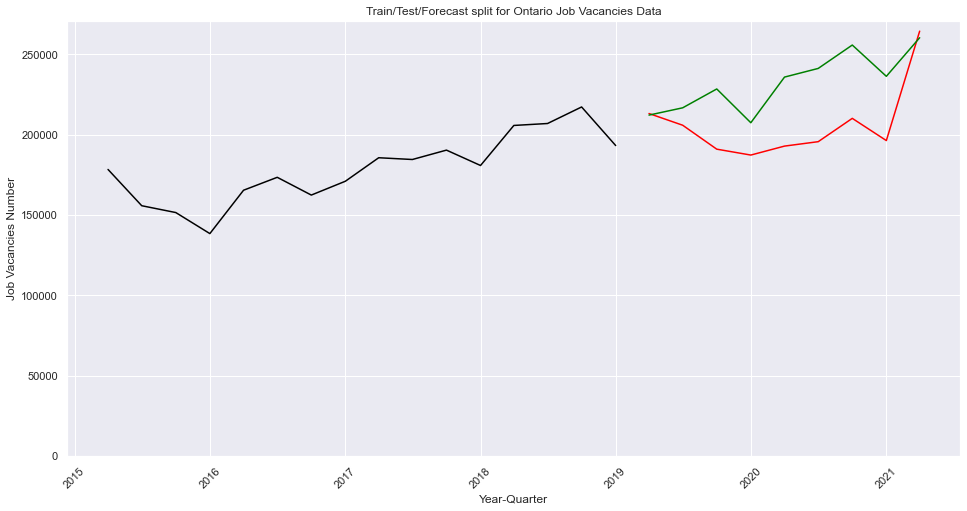

RMSE is 32593.829406551748


,test_Ontario,Prediction_Ontario
ref_date,,
2019-04-01,213225.0000,212247.731696
2019-07-01,205935.0000,216786.799565
2019-10-01,191030.0000,228520.101424
2020-01-01,187360.0000,207493.497437
2020-04-01,192941.8119,235923.829209
2020-07-01,195694.8163,241312.017293
2020-10-01,210215.0000,255879.437173
2021-01-01,196385.0000,236400.682741
2021-04-01,264530.0000,260436.238700


In [128]:
province_vac ('Ontario')

Stationary Test Results
      Values                       Metric
0  -0.076956              Test Statistics
1   0.951686                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6697224585822977
Two Quaretrs Lag:  0.6758661167080275
Three Quaretrs Lag:  0.5121048632270008
Four Quaretrs Lag:  0.5183513350392196
Trend Decomposition Visualization


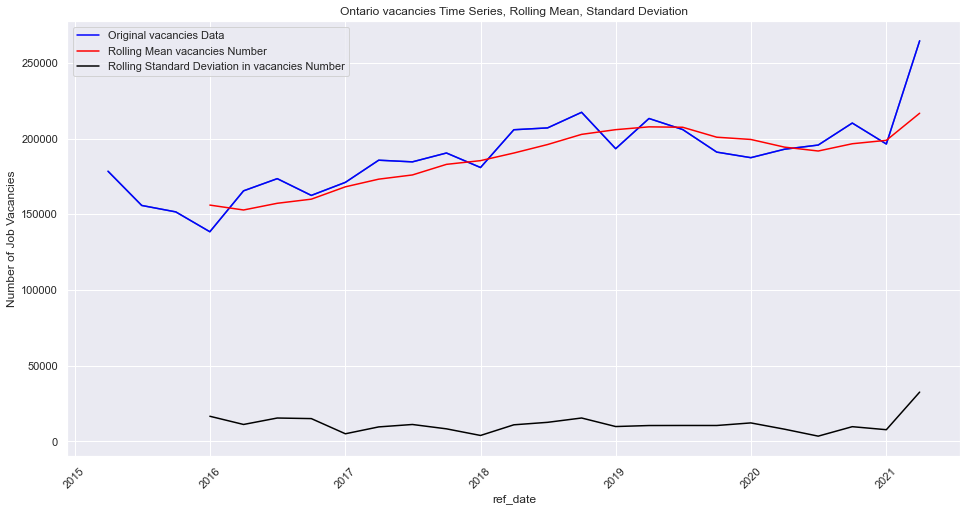

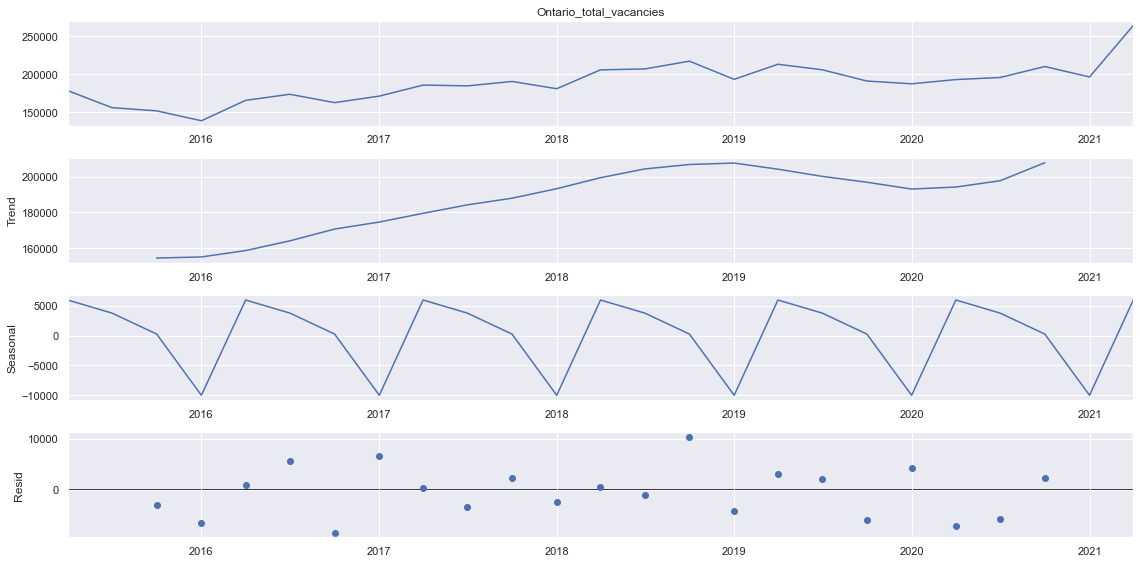

                                      SARIMAX Results                                      
Dep. Variable:                       train_Ontario   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -121.401
Date:                             Sun, 28 Nov 2021   AIC                            250.802
Time:                                     13:08:22   BIC                            252.394
Sample:                                 04-01-2015   HQIC                           249.799
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        190.4937    984.238      0.194      0.847   -1738.578    2119.565
ar.S.L4       -0.9466      

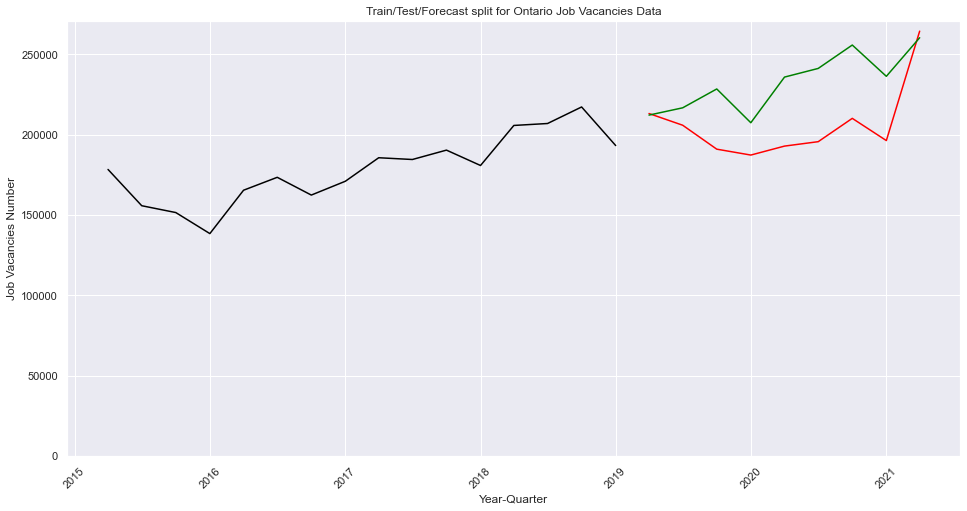

RMSE is 32593.829406551748
Stationary Test Results
      Values                       Metric
0   1.815474              Test Statistics
1   0.998379                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.9367128653017586
Two Quaretrs Lag:  0.9120243990796182
Three Quaretrs Lag:  0.8823146625462849
Four Quaretrs Lag:  0.8936462164831976
Trend Decomposition Visualization


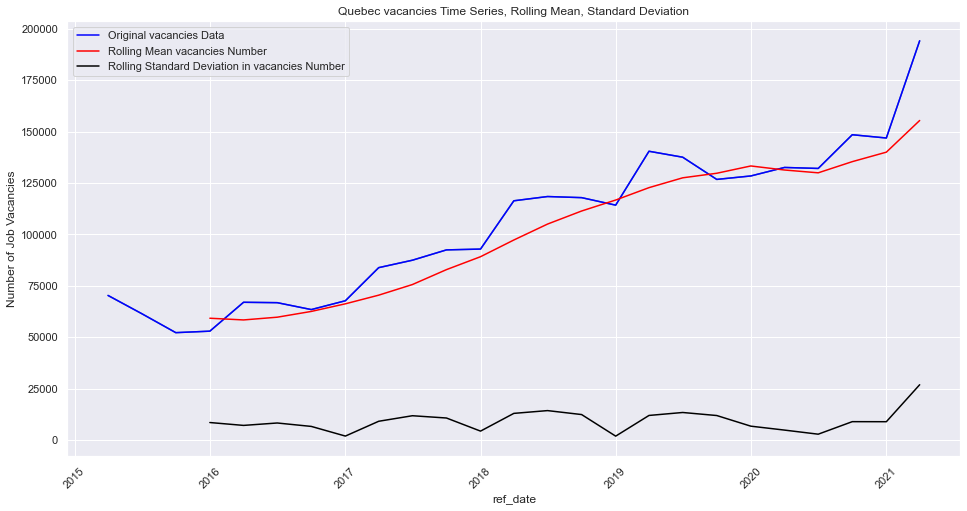

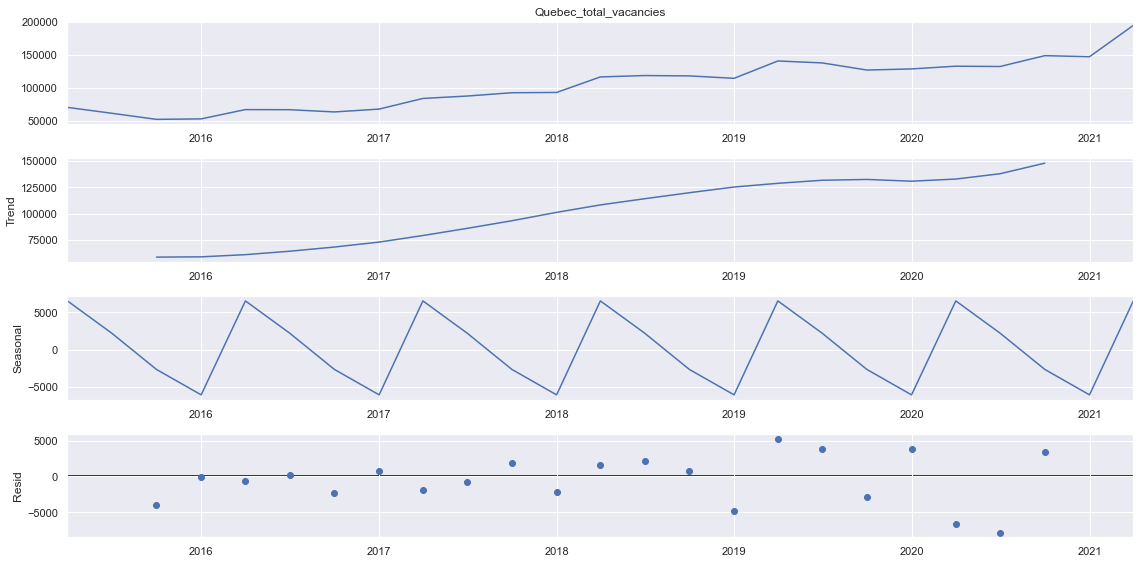

                                      SARIMAX Results                                      
Dep. Variable:                        train_Quebec   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -107.786
Date:                             Sun, 28 Nov 2021   AIC                            223.571
Time:                                     13:08:24   BIC                            225.163
Sample:                                 04-01-2015   HQIC                           222.568
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         39.6760     77.816      0.510      0.610    -112.842     192.193
ar.S.L4        0.3635      

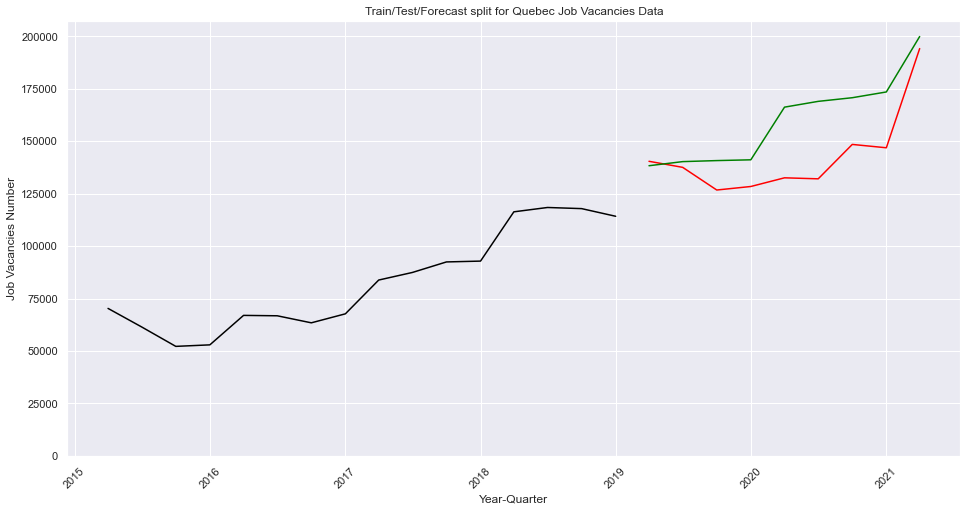

RMSE is 21356.65777229092
Stationary Test Results
      Values                       Metric
0  -1.813957              Test Statistics
1   0.373555                      p-value
2   8.000000             No. of lags used
3  16.000000  Number of observations used
4  -3.924019          critical value (1%)
5  -3.068498          critical value (5%)
6  -2.673893         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.8483707065024286
Two Quaretrs Lag:  0.7005846207322346
Three Quaretrs Lag:  0.7504770004137981
Four Quaretrs Lag:  0.7503639897053844
Trend Decomposition Visualization


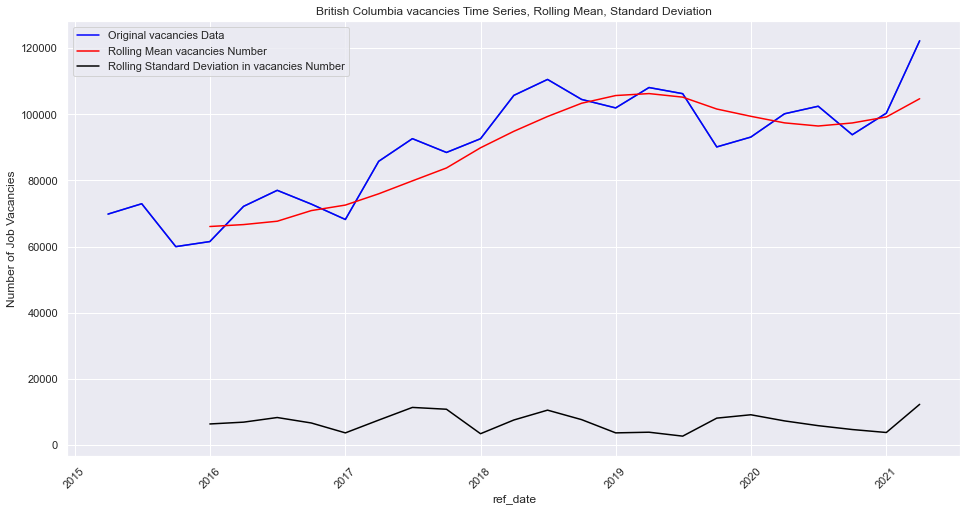

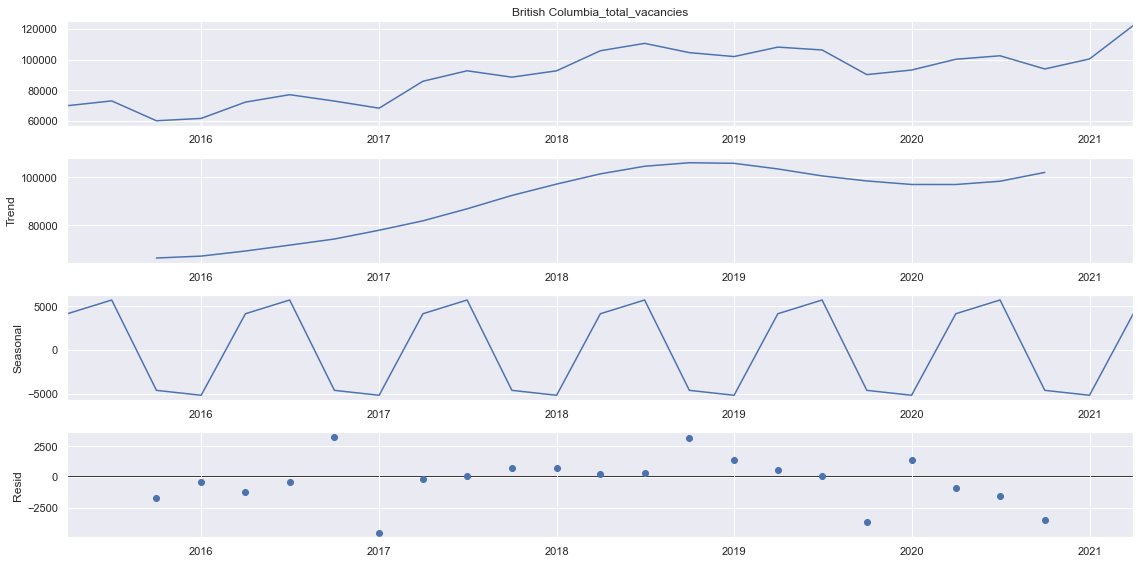

                                      SARIMAX Results                                      
Dep. Variable:              train_British Columbia   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -106.970
Date:                             Sun, 28 Nov 2021   AIC                            221.940
Time:                                     13:08:26   BIC                            223.532
Sample:                                 04-01-2015   HQIC                           220.937
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -42.3775     95.180     -0.445      0.656    -228.927     144.171
ar.S.L4        0.3306      

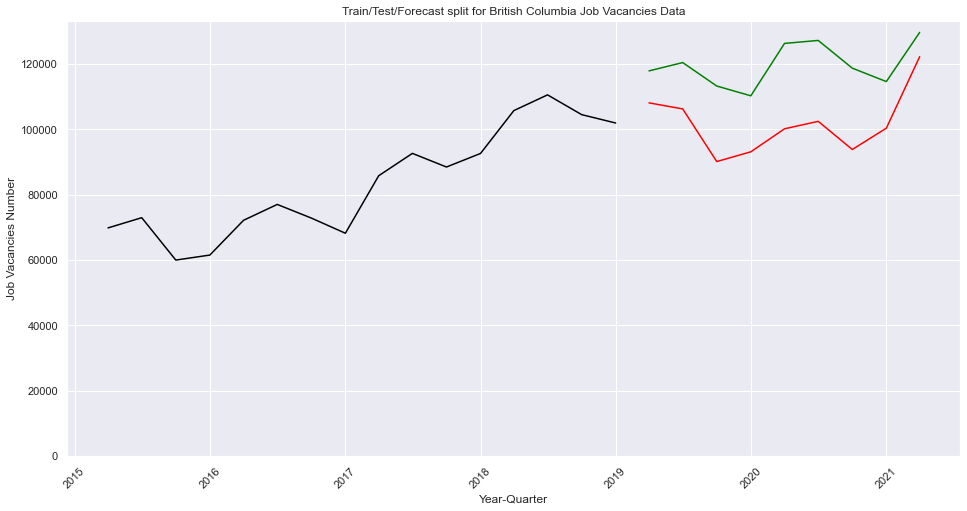

RMSE is 19158.1864702475
Stationary Test Results
      Values                       Metric
0  -2.826318              Test Statistics
1   0.054612                      p-value
2   8.000000             No. of lags used
3  16.000000  Number of observations used
4  -3.924019          critical value (1%)
5  -3.068498          critical value (5%)
6  -2.673893         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.538104401345235
Two Quaretrs Lag:  -0.030253119188166495
Three Quaretrs Lag:  -0.1354232103758833
Four Quaretrs Lag:  -0.12476405523916805
Trend Decomposition Visualization


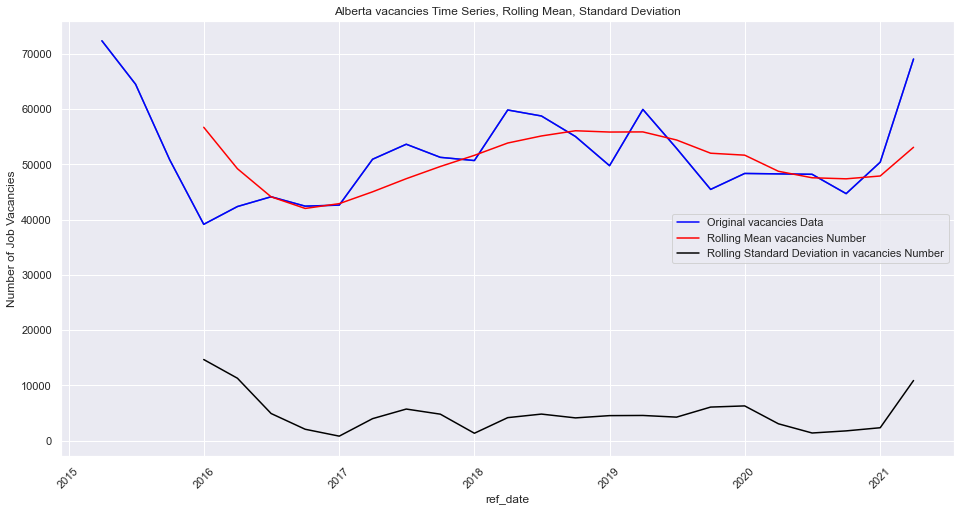

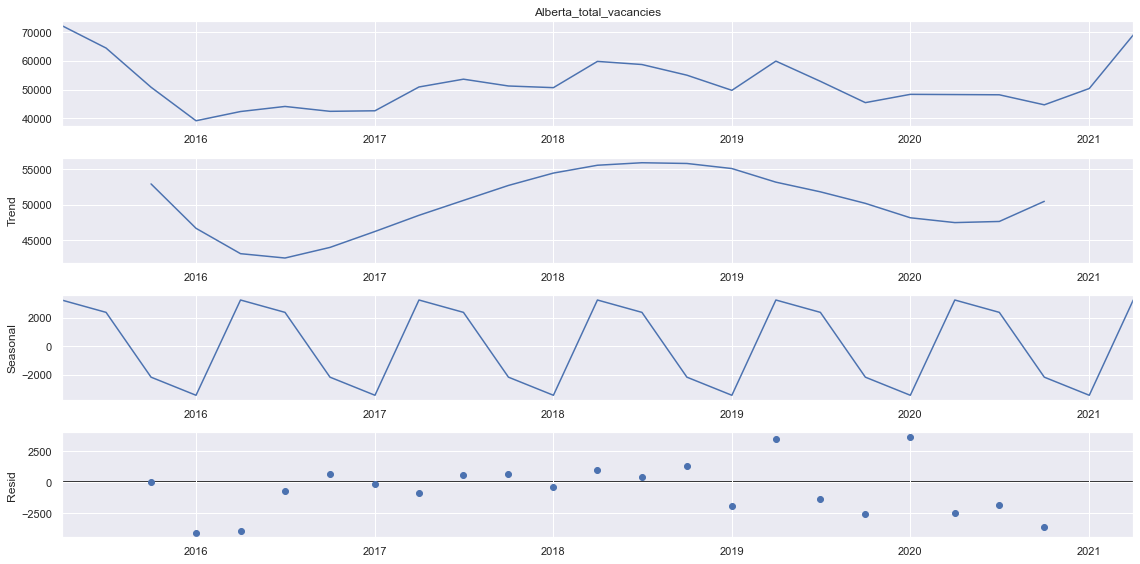

                                      SARIMAX Results                                      
Dep. Variable:                       train_Alberta   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                -108.490
Date:                             Sun, 28 Nov 2021   AIC                            224.979
Time:                                     13:08:28   BIC                            226.571
Sample:                                 04-01-2015   HQIC                           223.976
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -15.4396    162.338     -0.095      0.924    -333.616     302.737
ar.S.L4        0.4166      

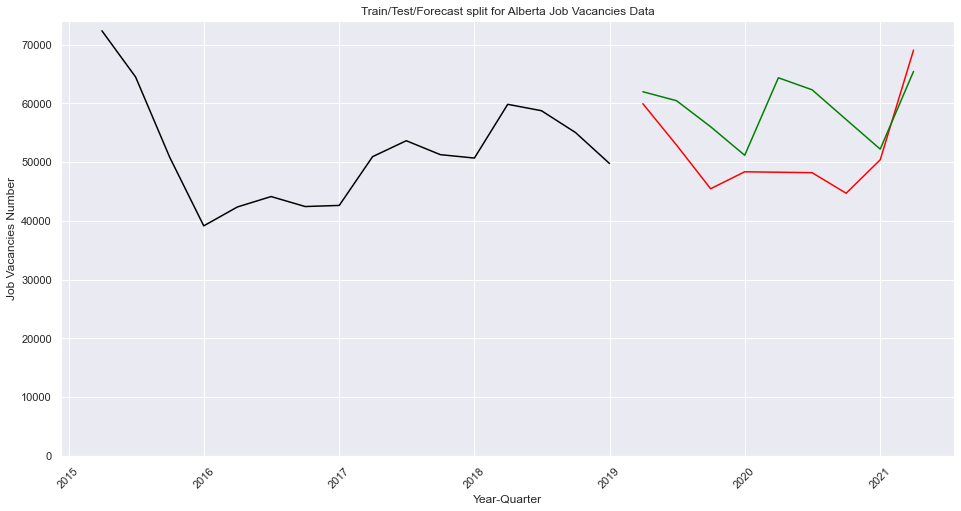

RMSE is 9495.310521419258
Stationary Test Results
      Values                       Metric
0  -0.391978              Test Statistics
1   0.911430                      p-value
2   5.000000             No. of lags used
3  19.000000  Number of observations used
4  -3.832603          critical value (1%)
5  -3.031227          critical value (5%)
6  -2.655520         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.8142787295268843
Two Quaretrs Lag:  0.773907407392514
Three Quaretrs Lag:  0.7051690123536881
Four Quaretrs Lag:  0.7443969090795258
Trend Decomposition Visualization


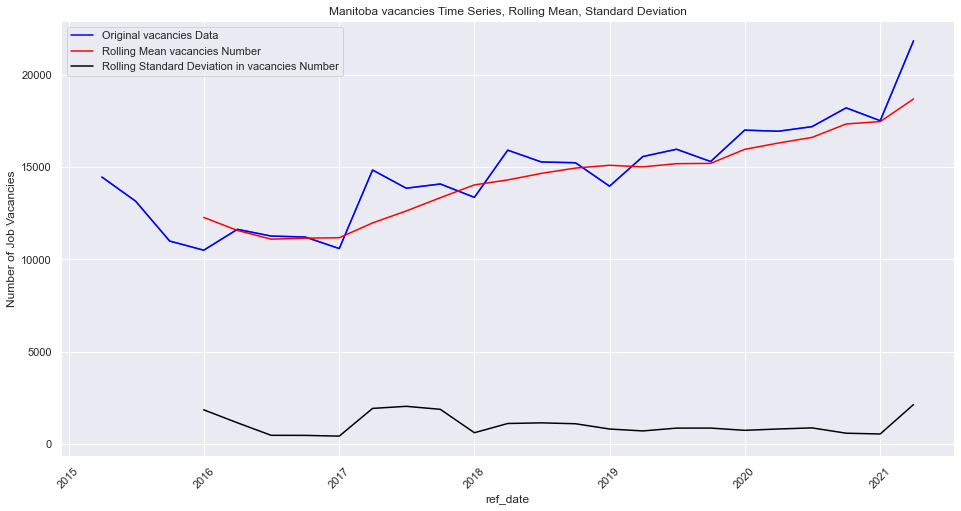

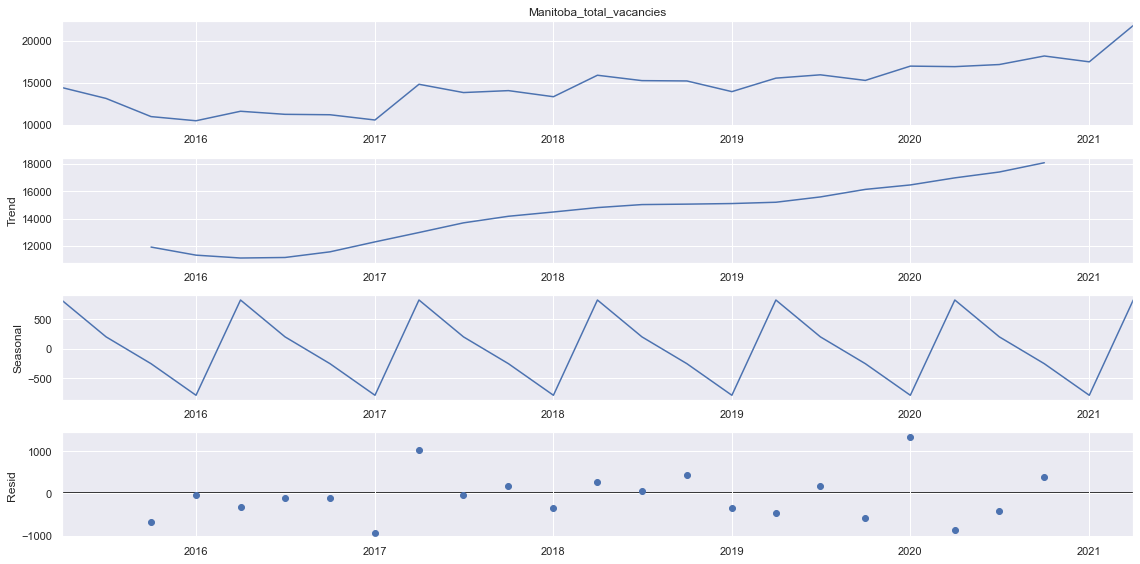

                                      SARIMAX Results                                      
Dep. Variable:                      train_Manitoba   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -87.582
Date:                             Sun, 28 Nov 2021   AIC                            183.165
Time:                                     13:08:30   BIC                            184.757
Sample:                                 04-01-2015   HQIC                           182.162
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          8.3419     44.535      0.187      0.851     -78.944      95.628
ar.S.L4       -0.5264      

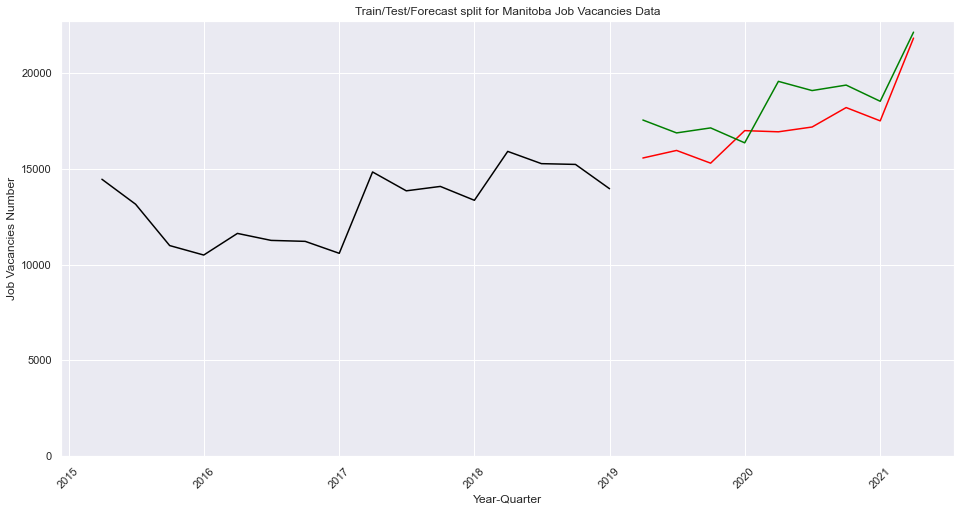

RMSE is 1551.9299047433417
Stationary Test Results
      Values                       Metric
0   2.074890              Test Statistics
1   0.998763                      p-value
2   7.000000             No. of lags used
3  17.000000  Number of observations used
4  -3.889266          critical value (1%)
5  -3.054358          critical value (5%)
6  -2.666984         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.4429502047632675
Two Quaretrs Lag:  0.02756496836239654
Three Quaretrs Lag:  0.1260514323017731
Four Quaretrs Lag:  0.26317854175517696
Trend Decomposition Visualization


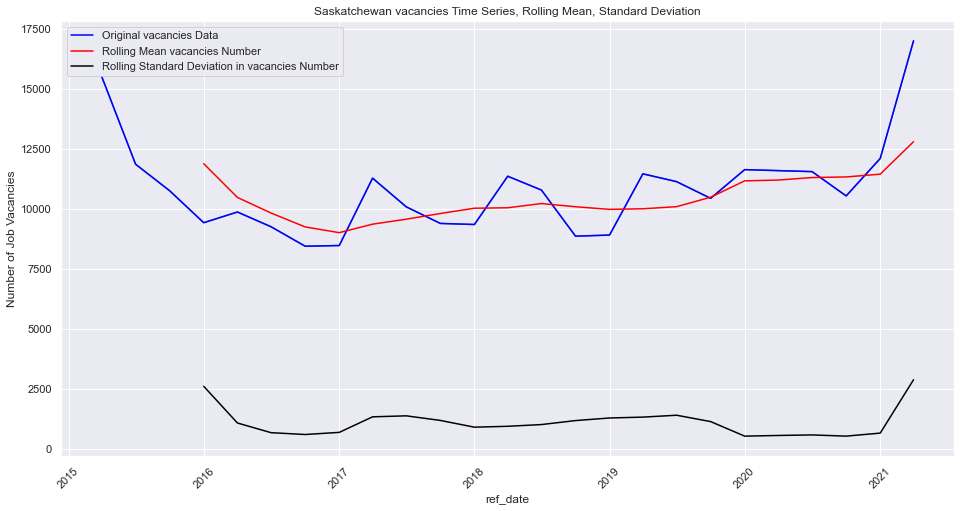

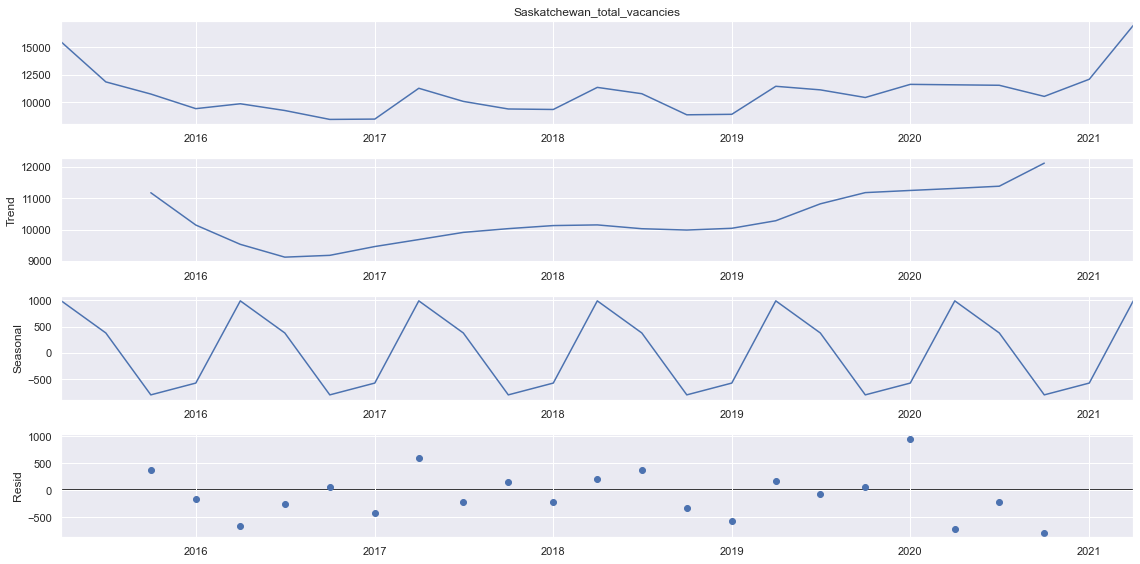

                                      SARIMAX Results                                      
Dep. Variable:                  train_Saskatchewan   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -89.963
Date:                             Sun, 28 Nov 2021   AIC                            187.926
Time:                                     13:08:31   BIC                            189.517
Sample:                                 04-01-2015   HQIC                           186.922
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         14.4930     37.735      0.384      0.701     -59.466      88.452
ar.S.L4       -0.3449      

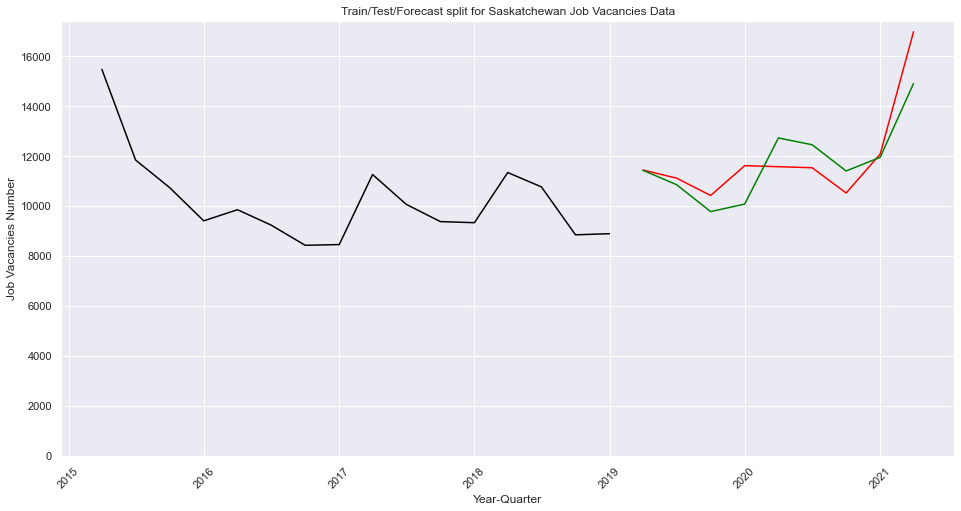

RMSE is 1060.065549607754
Stationary Test Results
      Values                       Metric
0  -3.523826              Test Statistics
1   0.007396                      p-value
2   9.000000             No. of lags used
3  15.000000  Number of observations used
4  -3.964443          critical value (1%)
5  -3.084908          critical value (5%)
6  -2.681814         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6282796536620597
Two Quaretrs Lag:  0.4058210520381216
Three Quaretrs Lag:  0.4670556033892479
Four Quaretrs Lag:  0.7466441096849072
Trend Decomposition Visualization


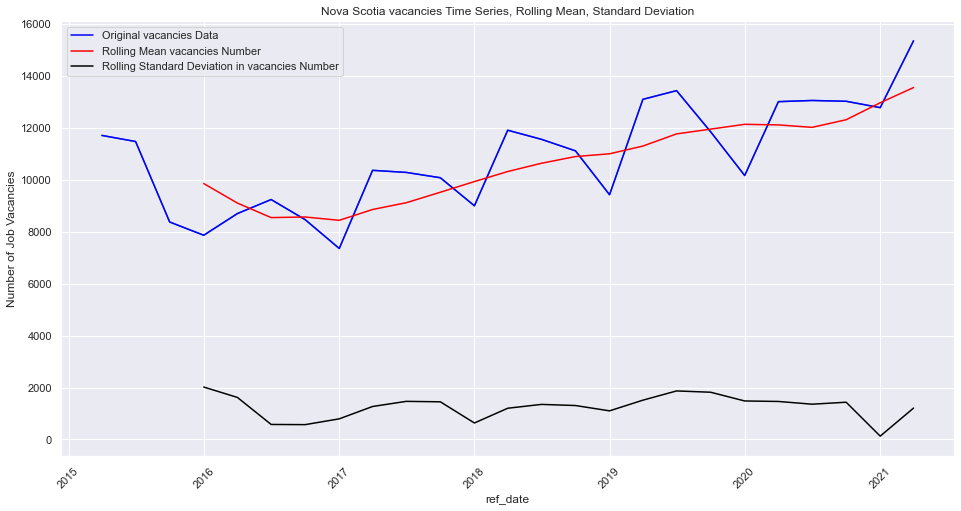

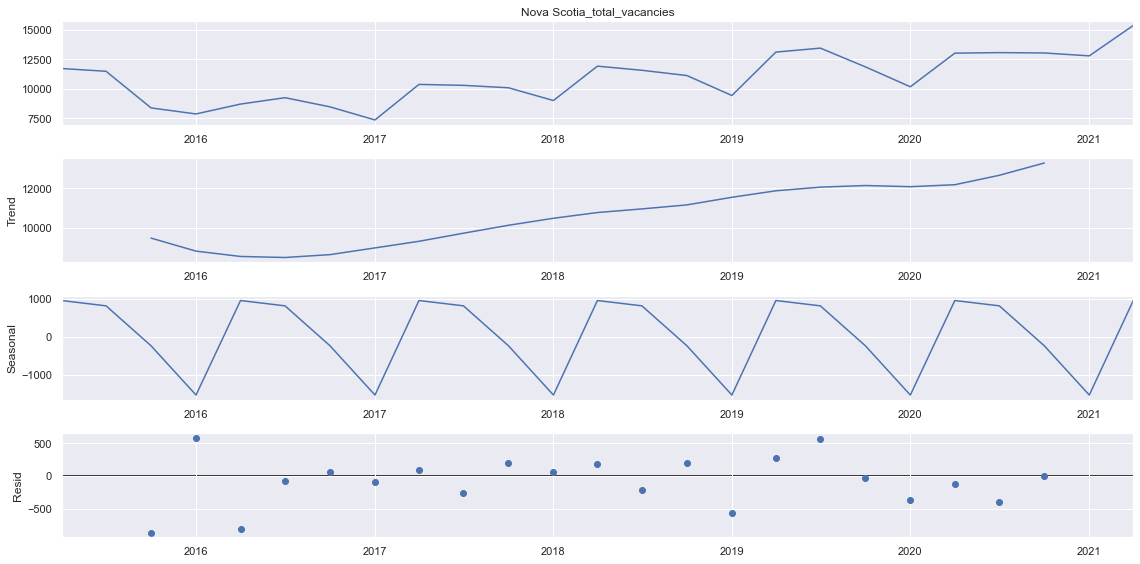

                                      SARIMAX Results                                      
Dep. Variable:                   train_Nova Scotia   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -89.106
Date:                             Sun, 28 Nov 2021   AIC                            186.212
Time:                                     13:08:33   BIC                            187.804
Sample:                                 04-01-2015   HQIC                           185.209
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          3.7801     31.025      0.122      0.903     -57.028      64.588
ar.S.L4       -0.0576      

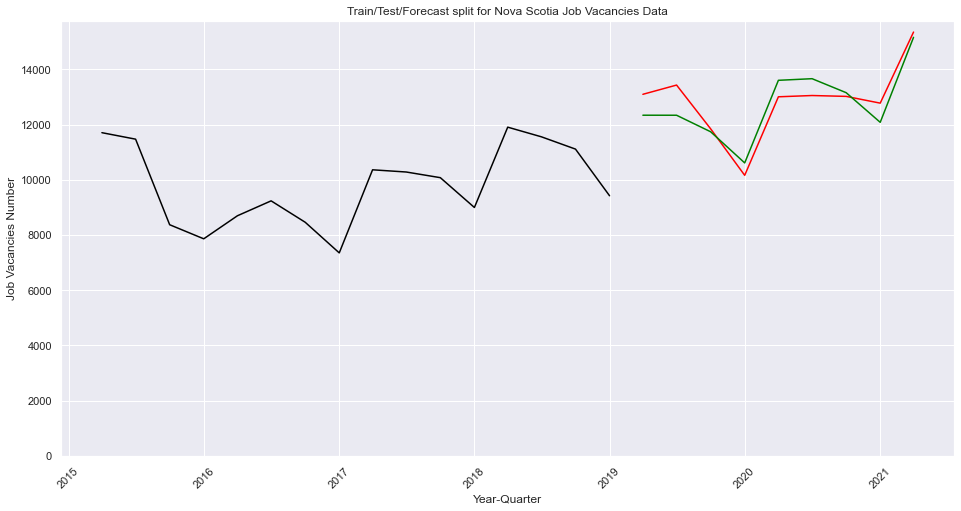

RMSE is 600.7302019114732
Stationary Test Results
      Values                       Metric
0   1.106262              Test Statistics
1   0.995270                      p-value
2   3.000000             No. of lags used
3  21.000000  Number of observations used
4  -3.788386          critical value (1%)
5  -3.013098          critical value (5%)
6  -2.646397         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6053190502244362
Two Quaretrs Lag:  0.5659454575803591
Three Quaretrs Lag:  0.48419168363881987
Four Quaretrs Lag:  0.7791124226199606
Trend Decomposition Visualization


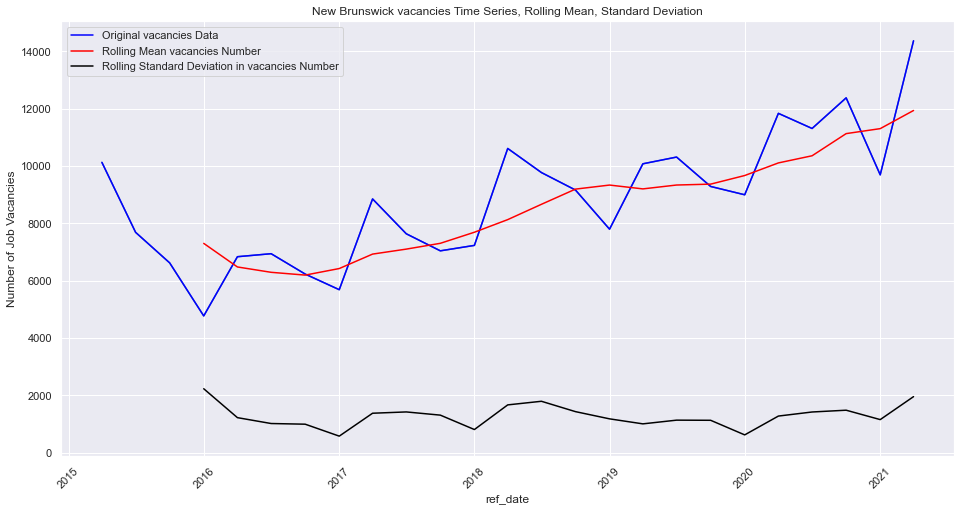

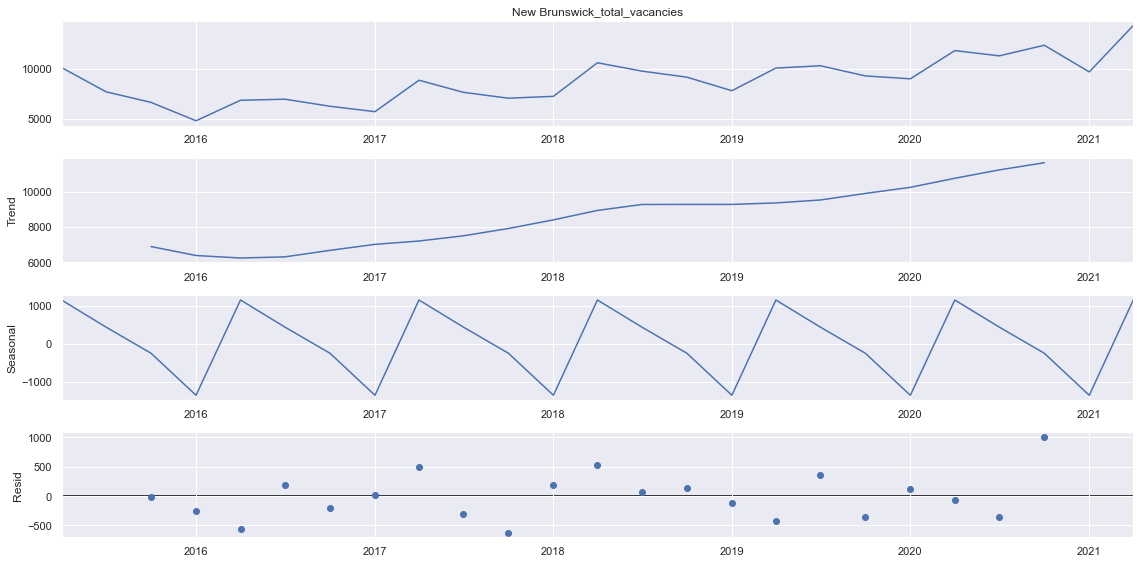

                                      SARIMAX Results                                      
Dep. Variable:                 train_New Brunswick   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -87.828
Date:                             Sun, 28 Nov 2021   AIC                            183.657
Time:                                     13:08:35   BIC                            185.248
Sample:                                 04-01-2015   HQIC                           182.653
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         11.2987     25.710      0.439      0.660     -39.092      61.690
ar.S.L4       -0.2591      

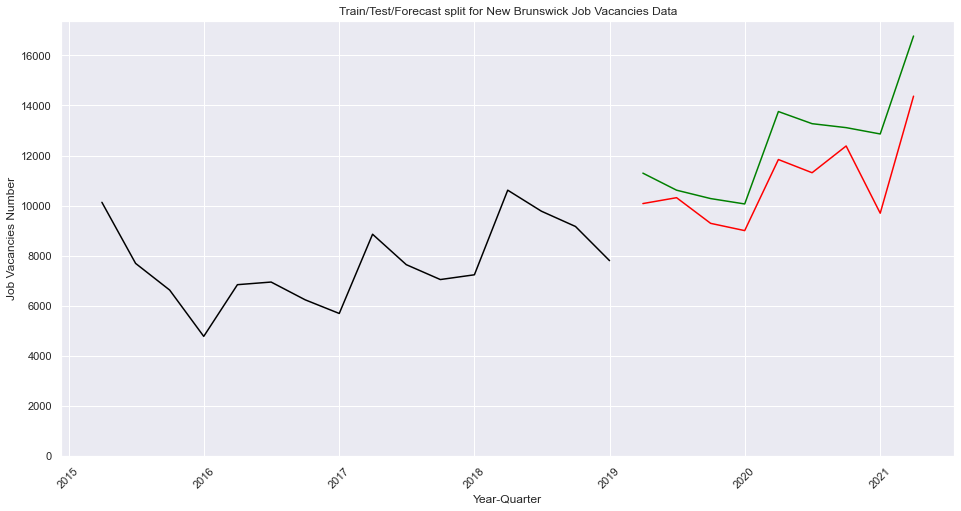

RMSE is 1748.6848016001009
Stationary Test Results
      Values                       Metric
0  -2.318937              Test Statistics
1   0.165933                      p-value
2   8.000000             No. of lags used
3  16.000000  Number of observations used
4  -3.924019          critical value (1%)
5  -3.068498          critical value (5%)
6  -2.673893         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.2500486964494063
Two Quaretrs Lag:  0.34732539721568056
Three Quaretrs Lag:  0.23150820740729236
Four Quaretrs Lag:  0.5089098151745148
Trend Decomposition Visualization


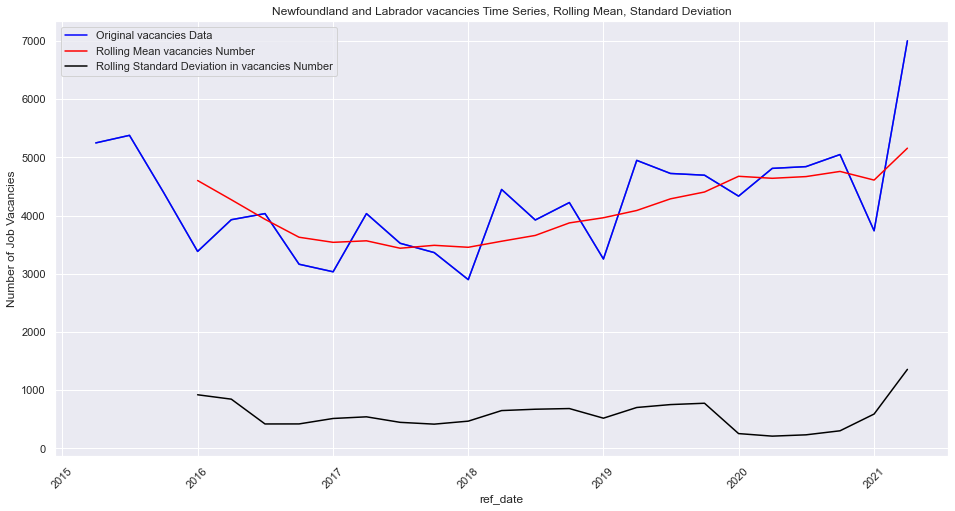

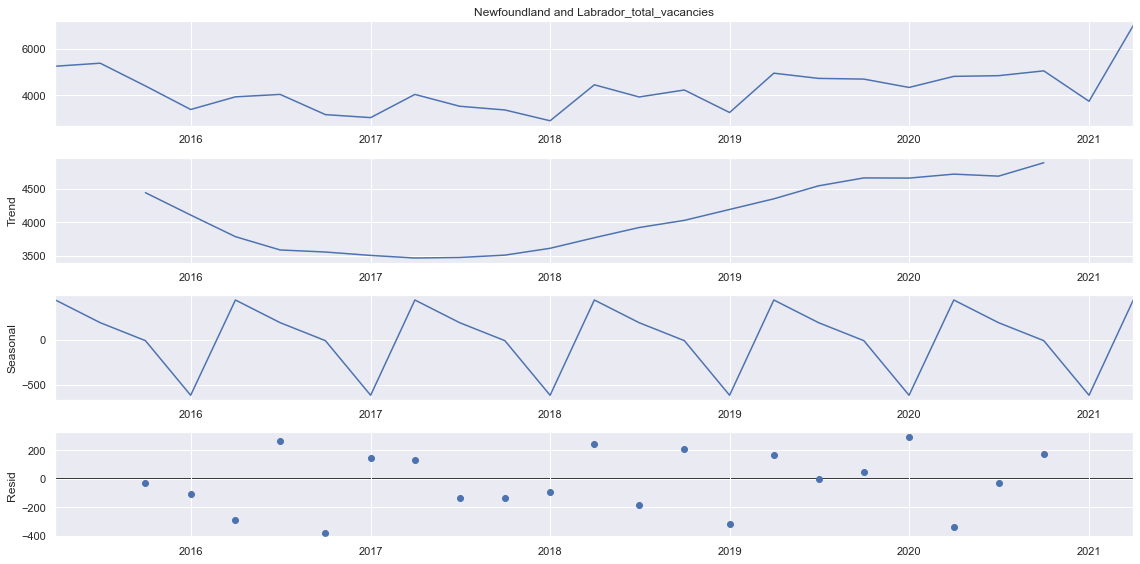

                                      SARIMAX Results                                      
Dep. Variable:     train_Newfoundland and Labrador   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -83.284
Date:                             Sun, 28 Nov 2021   AIC                            174.568
Time:                                     13:08:37   BIC                            176.160
Sample:                                 04-01-2015   HQIC                           173.565
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         19.3578     22.060      0.877      0.380     -23.880      62.596
ar.S.L4       -0.6475      

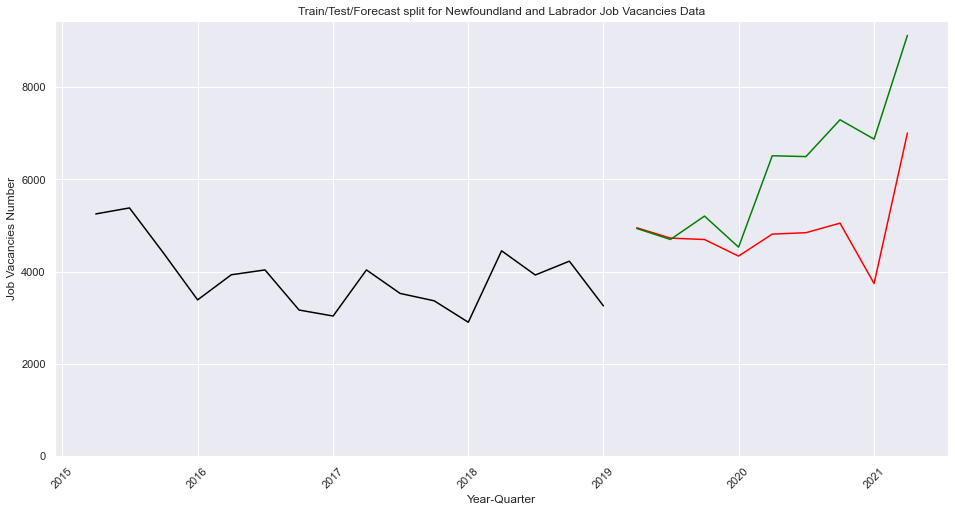

RMSE is 1674.964012580913
Stationary Test Results
      Values                       Metric
0  -0.735839              Test Statistics
1   0.837247                      p-value
2   9.000000             No. of lags used
3  15.000000  Number of observations used
4  -3.964443          critical value (1%)
5  -3.084908          critical value (5%)
6  -2.681814         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.25360963296194006
Two Quaretrs Lag:  -0.02251589591272195
Three Quaretrs Lag:  0.22636175318709068
Four Quaretrs Lag:  0.7714831807843053
Trend Decomposition Visualization


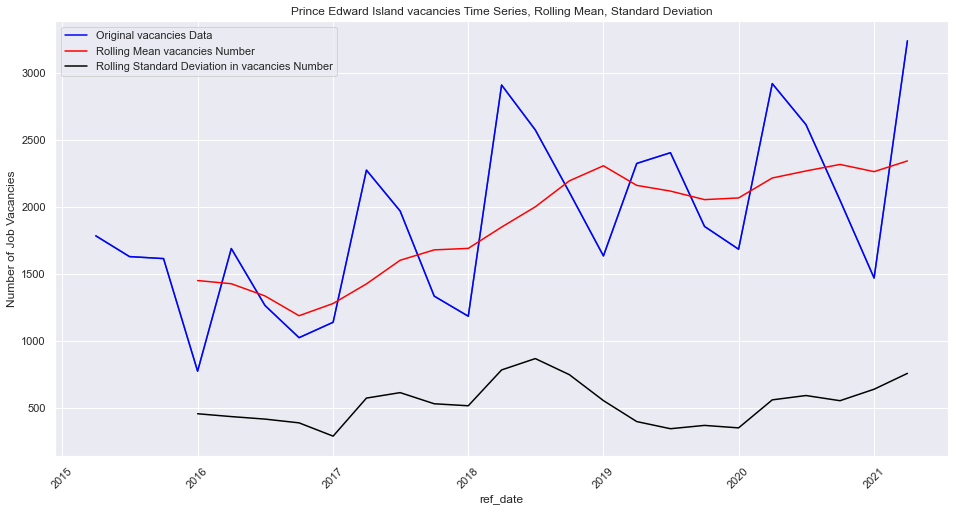

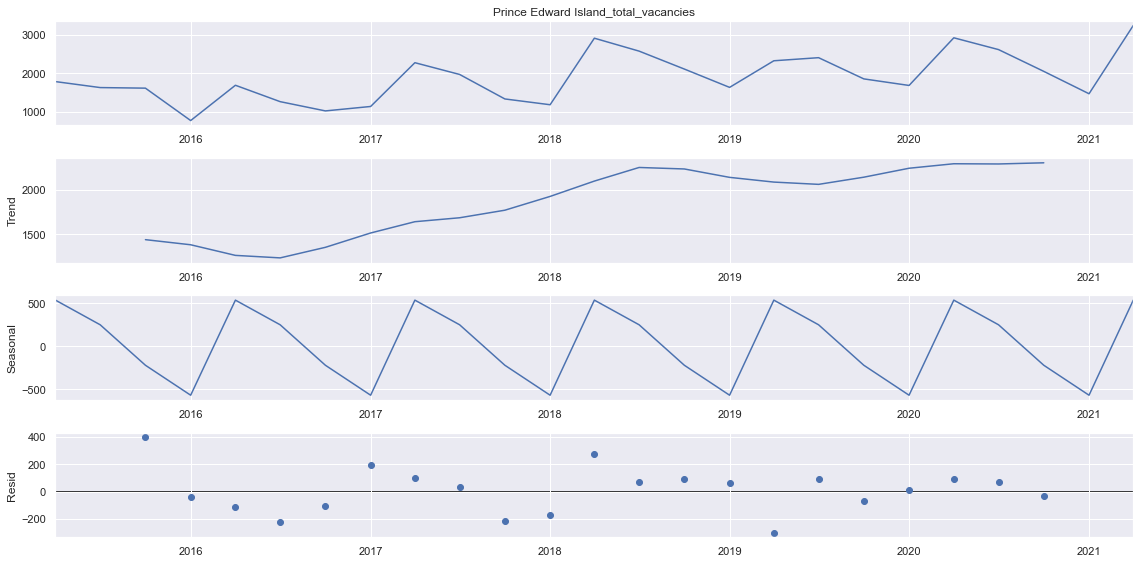

                                      SARIMAX Results                                      
Dep. Variable:          train_Prince Edward Island   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -81.286
Date:                             Sun, 28 Nov 2021   AIC                            170.572
Time:                                     13:08:39   BIC                            172.164
Sample:                                 04-01-2015   HQIC                           169.569
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          1.3708     10.927      0.125      0.900     -20.046      22.787
ar.S.L4        0.3767      

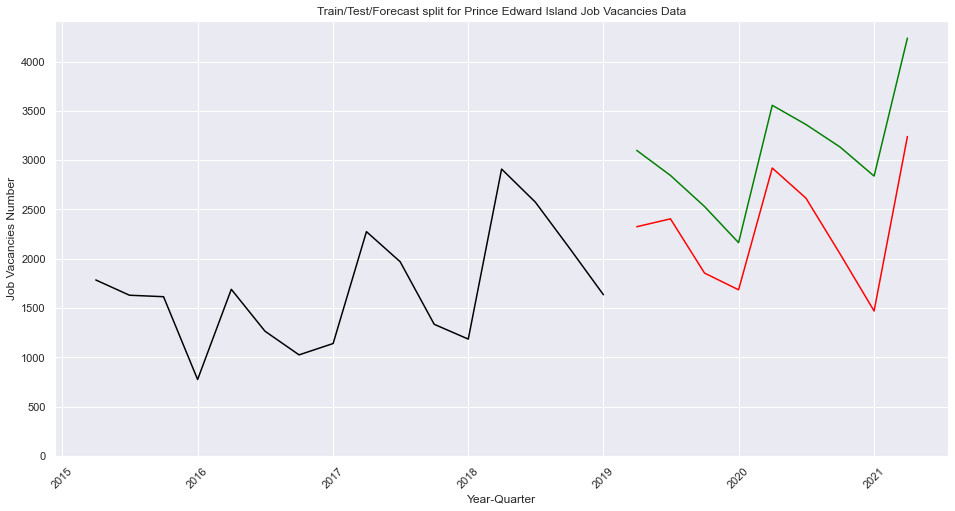

RMSE is 848.9523907770745
Stationary Test Results
      Values                       Metric
0  -1.154288              Test Statistics
1   0.692945                      p-value
2   9.000000             No. of lags used
3  15.000000  Number of observations used
4  -3.964443          critical value (1%)
5  -3.084908          critical value (5%)
6  -2.681814         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.5088271248293985
Two Quaretrs Lag:  0.26435117045627493
Three Quaretrs Lag:  0.5526379603931019
Four Quaretrs Lag:  0.7782743437690689
Trend Decomposition Visualization


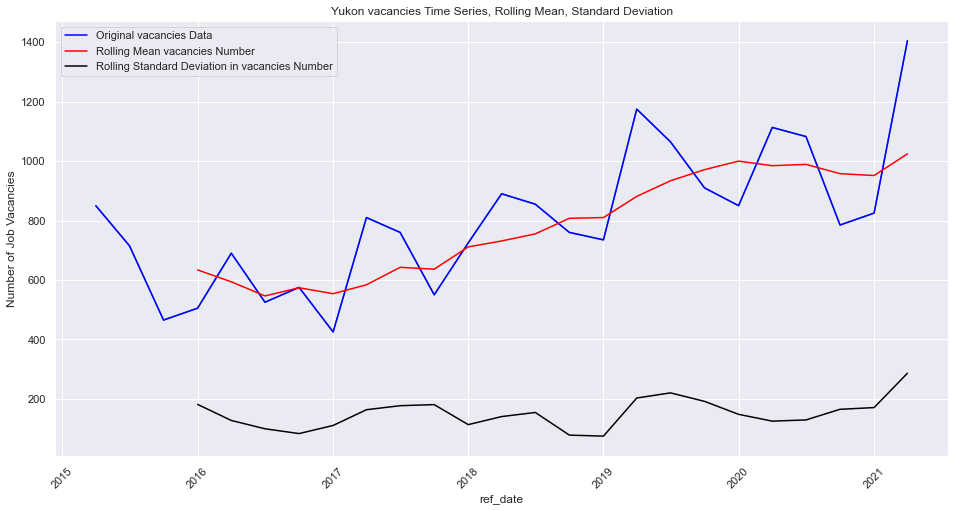

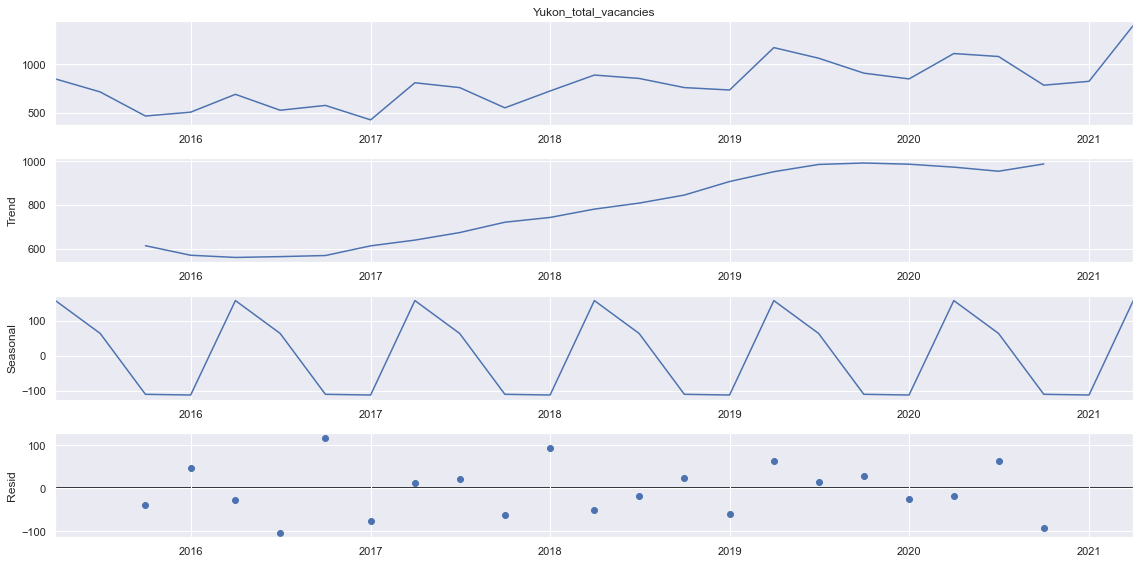

                                      SARIMAX Results                                      
Dep. Variable:                         train_Yukon   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -68.159
Date:                             Sun, 28 Nov 2021   AIC                            144.318
Time:                                     13:08:41   BIC                            145.910
Sample:                                 04-01-2015   HQIC                           143.315
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          3.3140      2.906      1.141      0.254      -2.381       9.009
ar.S.L4       -0.6412      

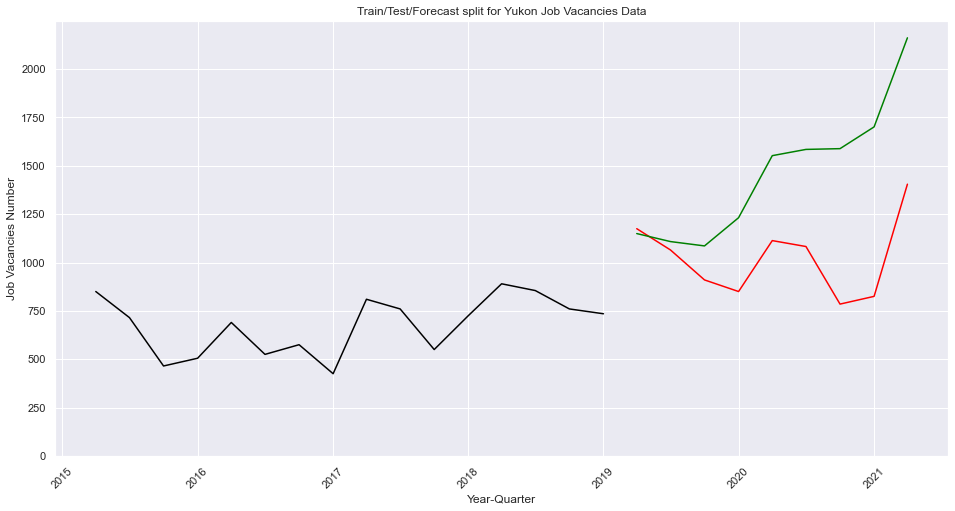

RMSE is 538.6445821295638
Stationary Test Results
      Values                       Metric
0  -0.538492              Test Statistics
1   0.884284                      p-value
2   2.000000             No. of lags used
3  22.000000  Number of observations used
4  -3.769733          critical value (1%)
5  -3.005426          critical value (5%)
6  -2.642501         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6024468540435151
Two Quaretrs Lag:  0.2113168200887244
Three Quaretrs Lag:  0.3607903139276032
Four Quaretrs Lag:  0.47877253786135177
Trend Decomposition Visualization


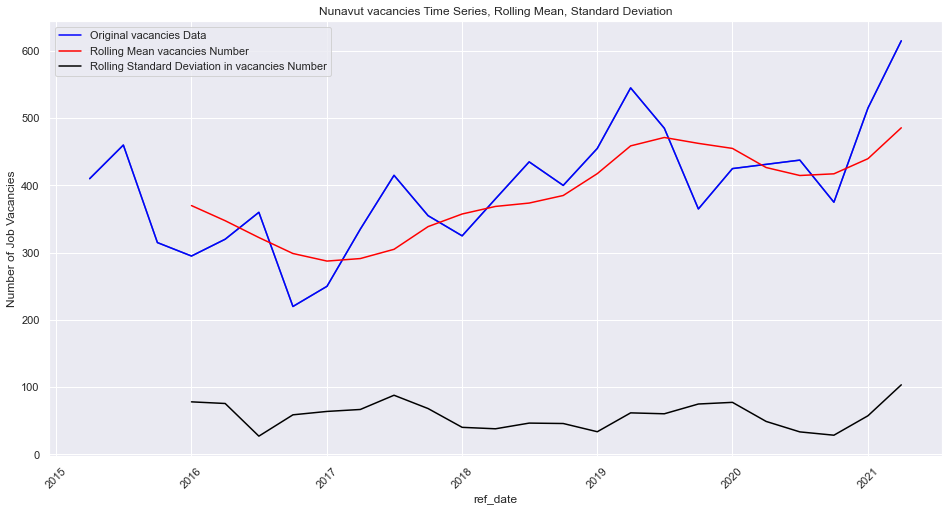

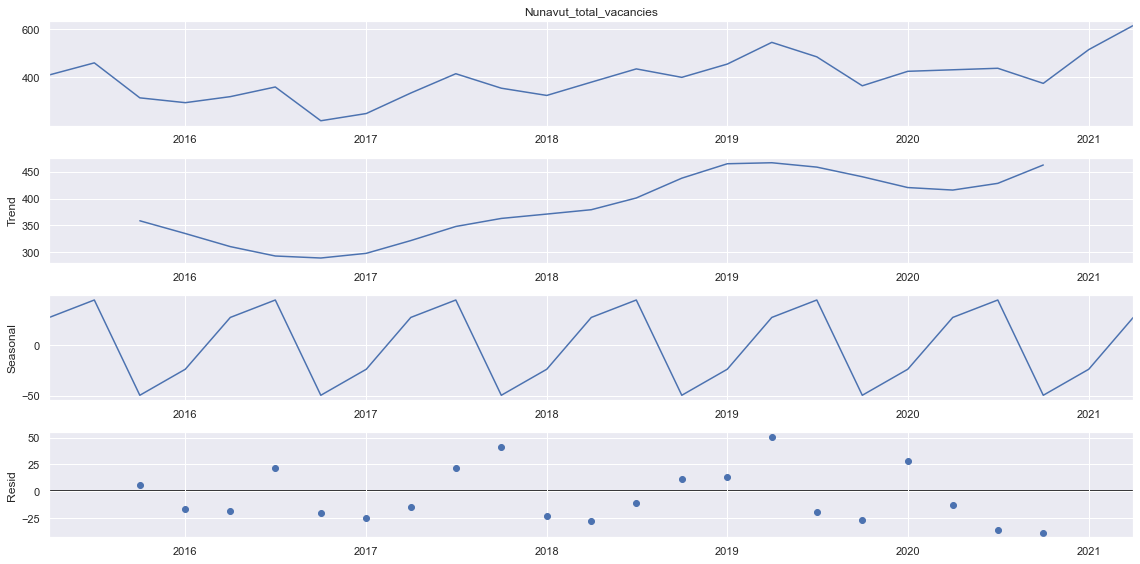

                                      SARIMAX Results                                      
Dep. Variable:                       train_Nunavut   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -54.642
Date:                             Sun, 28 Nov 2021   AIC                            117.284
Time:                                     13:08:43   BIC                            118.875
Sample:                                 04-01-2015   HQIC                           116.281
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          3.1664      1.248      2.537      0.011       0.721       5.612
ar.S.L4       -0.9998      

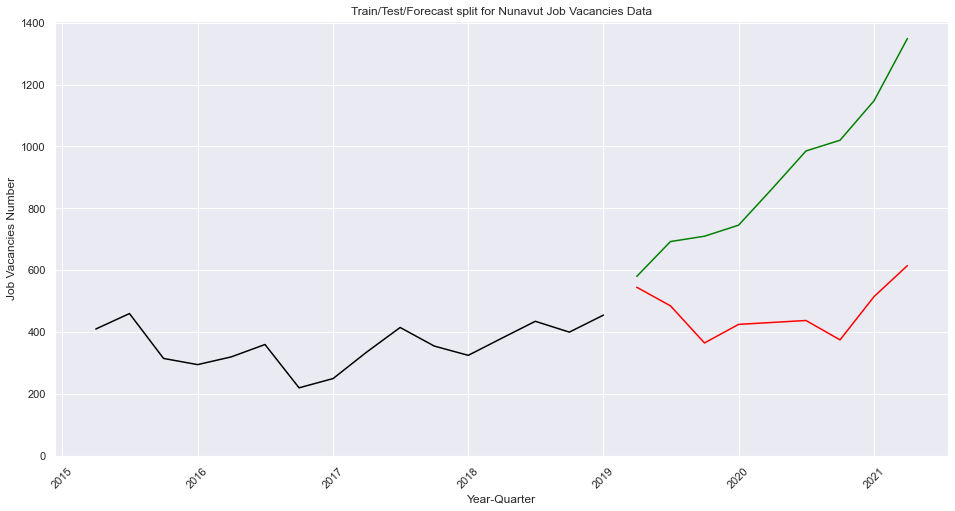

RMSE is 484.0573196377494
Stationary Test Results
      Values                       Metric
0  -2.855894              Test Statistics
1   0.050723                      p-value
2   3.000000             No. of lags used
3  21.000000  Number of observations used
4  -3.788386          critical value (1%)
5  -3.013098          critical value (5%)
6  -2.646397         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.622066750883661
Two Quaretrs Lag:  0.09221660903272236
Three Quaretrs Lag:  -0.23320948715617024
Four Quaretrs Lag:  -0.5026472260459147
Trend Decomposition Visualization


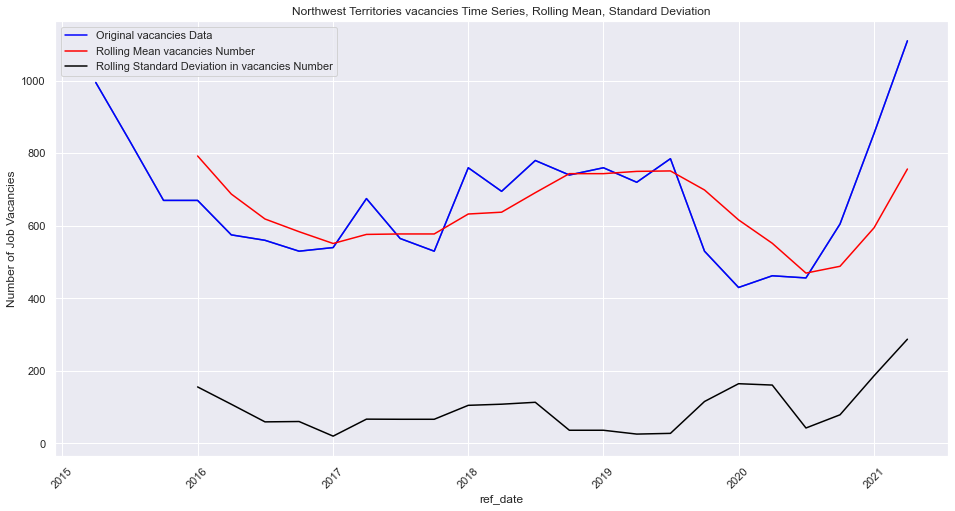

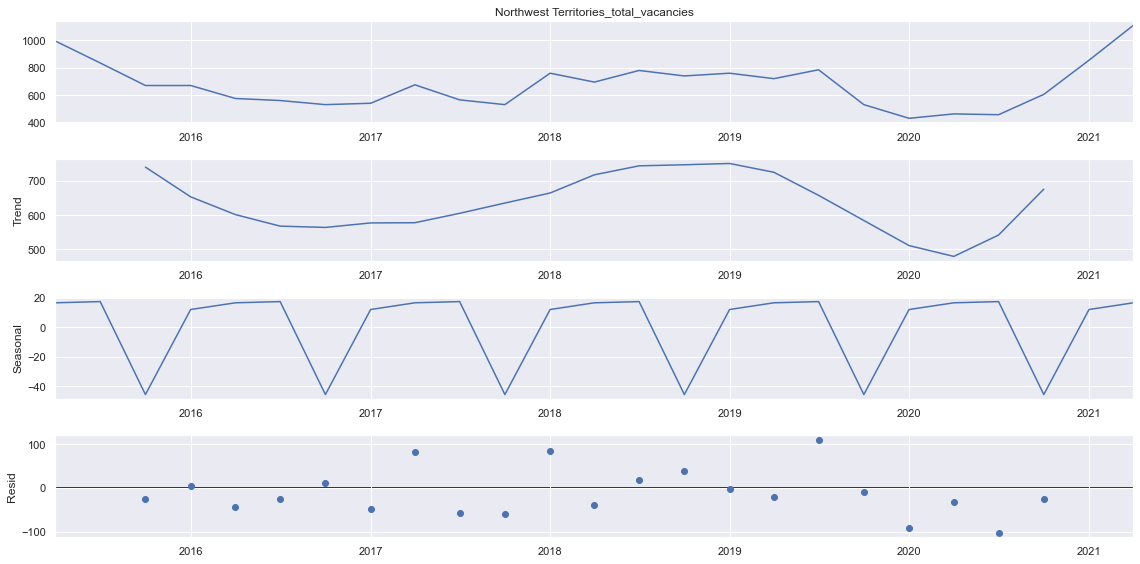

                                      SARIMAX Results                                      
Dep. Variable:         train_Northwest Territories   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 4)   Log Likelihood                 -65.133
Date:                             Sun, 28 Nov 2021   AIC                            138.267
Time:                                     13:08:45   BIC                            139.858
Sample:                                 04-01-2015   HQIC                           137.263
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          5.8302      2.605      2.238      0.025       0.724      10.936
ar.S.L4       -0.8017      

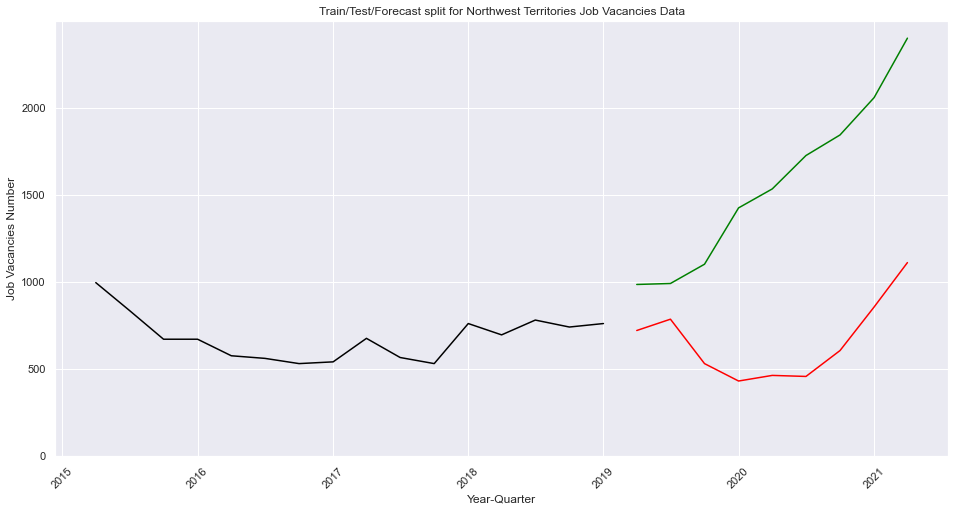

RMSE is 989.9476312316996
            test_Ontario  Prediction_Ontario  test_Quebec  Prediction_Quebec  \
ref_date                                                                       
2019-04-01   213225.0000       212247.731696  140420.0000      138305.633797   
2019-07-01   205935.0000       216786.799565  137530.0000      140267.629829   
2019-10-01   191030.0000       228520.101424  126730.0000      140757.223422   
2020-01-01   187360.0000       207493.497437  128410.0000      141127.130484   
2020-04-01   192941.8119       235923.829209  132545.1835      166231.433272   
2020-07-01   195694.8163       241312.017293  132064.3476      168987.365211   
2020-10-01   210215.0000       255879.437173  148460.0000      170724.090177   
2021-01-01   196385.0000       236400.682741  146865.0000      173467.790822   
2021-04-01   264530.0000       260436.238700  194145.0000      199892.788314   

            test_British Columbia  Prediction_British Columbia  test_Alberta  \
ref_date     

In [129]:
# produce all provinces prediction test results
provinces = ['Ontario', 'Quebec', 'British Columbia','Alberta',\
             'Manitoba', 'Saskatchewan','Nova Scotia', 'New Brunswick','Newfoundland and Labrador',\
             'Prince Edward Island', 'Yukon', 'Nunavut' ,'Northwest Territories']

output_provencies= province_vac("Ontario")

for prov in provinces[1:13]:
    output_provencies = pd.merge(output_provencies , province_vac(prov), left_index=True, right_index=True)
          
    
#output_provencies
print(output_provencies)

In [130]:
output_provencies

,test_Ontario,Prediction_Ontario,test_Quebec,Prediction_Quebec,test_British Columbia,Prediction_British Columbia,test_Alberta,Prediction_Alberta,test_Manitoba,Prediction_Manitoba,...,test_Newfoundland and Labrador,Prediction_Newfoundland and Labrador,test_Prince Edward Island,Prediction_Prince Edward Island,test_Yukon,Prediction_Yukon,test_Nunavut,Prediction_Nunavut,test_Northwest Territories,Prediction_Northwest Territories
ref_date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,213225.0000,212247.731696,140420.0000,138305.633797,108115.0000,117899.927617,59930.00000,61972.577560,15565.00000,17549.791022,...,4950.000000,4934.927519,2325.000000,3099.318370,1175.000000,1149.717776,545.000000,579.988186,720.000000,984.417740
2019-07-01,205935.0000,216786.799565,137530.0000,140267.629829,106260.0000,120452.860125,52890.00000,60441.321854,15960.00000,16875.991179,...,4725.000000,4695.679183,2405.000000,2845.272736,1065.000000,1108.332810,485.000000,692.668758,785.000000,989.998336
2019-10-01,191030.0000,228520.101424,126730.0000,140757.223422,90140.0000,113270.905367,45465.00000,56014.910856,15295.00000,17137.681135,...,4695.000000,5202.852493,1855.000000,2530.272247,910.000000,1085.865639,365.000000,709.964533,530.000000,1100.668601
2020-01-01,187360.0000,207493.497437,128410.0000,141127.130484,93125.0000,110274.870338,48350.00000,51157.134048,16995.00000,16357.414884,...,4335.000000,4528.953566,1685.000000,2163.209105,850.000000,1231.686047,425.000000,745.592773,430.000000,1424.092090
2020-04-01,192941.8119,235923.829209,132545.1835,166231.433272,100171.1173,126319.583170,48273.51128,64345.986880,16933.82862,19569.291378,...,4812.289578,6511.916371,2920.423190,3556.740495,1113.305809,1552.573246,431.300752,863.931606,462.226052,1533.093586
2020-07-01,195694.8163,241312.017293,132064.3476,168987.365211,102454.3798,127233.007443,48197.02256,62304.584052,17184.18819,19088.465024,...,4842.348548,6494.172805,2614.571134,3361.978346,1082.704106,1584.875727,437.601504,985.435009,456.296235,1724.778239
2020-10-01,210215.0000,255879.437173,148460.0000,170724.090177,93835.0000,118744.478852,44700.00000,57242.119827,18200.00000,19374.856021,...,5050.000000,7293.084292,2050.000000,3133.642535,785.000000,1588.810680,375.000000,1020.104021,605.000000,1842.924072
2021-01-01,196385.0000,236400.682741,146865.0000,173467.790822,100365.0000,114632.896668,50390.00000,52203.050972,17505.00000,18528.639445,...,3740.000000,6872.705096,1470.000000,2838.769201,825.000000,1701.328666,515.000000,1147.928697,855.000000,2057.193869
2021-04-01,264530.0000,260436.238700,194145.0000,199892.788314,122260.0000,129690.234819,69050.00000,65425.996017,21830.00000,22139.669953,...,7005.000000,9124.055919,3240.000000,4238.533102,1405.000000,2161.912299,615.000000,1348.909885,1110.000000,2398.648145


In [131]:
#make future predictions for all provinces

future_predictions= ['2021-07-01','2021-10-01',\
                     '2022-01-01','2022-04-01','2022-07-01','2022-10-01',\
                     '2023-01-01','2023-04-01','2023-07-01','2023-10-01',\
                    '2024-01-01','2024-04-01','2024-07-01','2024-10-01',\
                     '2025-01-01','2025-04-01']

provinces = ['Ontario', 'Quebec', 'British Columbia','Alberta',\
             'Manitoba', 'Saskatchewan','Nova Scotia', 'New Brunswick','Newfoundland and Labrador',\
             'Prince Edward Island', 'Yukon', 'Nunavut' ,'Northwest Territories']

#output_provencies= province_vac("Ontario")
prov_predictions={}
for prov in provinces[0:13]:
    #load province model
    loaded= SARIMAXResults.load(f'TSmodel_{prov}.pkl')
    #produce future forecast for each province
    
    
    res = []
    for q in future_predictions:
        res.append(loaded.predict(q))
    res_prov= pd.concat(res)
    prov_predictions[prov]= res_prov
    #print(prov_predictions)
    print(prov_predictions)
    
    #output_provencies = pd.merge(output_provencies , province_vac(prov), left_index=True, right_index=True)
          

{'Ontario': 2021-07-01    269783.003502
2021-10-01    286620.524102
2022-01-01    270819.926810
2022-04-01    304349.335107
2022-07-01    315473.285576
2022-10-01    335876.771980
2023-01-01    322499.788703
2023-04-01    353138.253355
2023-07-01    368866.236715
2023-10-01    392371.016767
2024-01-01    383367.154150
2024-04-01    423599.915032
2024-07-01    442018.054008
2024-10-01    469825.954140
2025-01-01    464111.812564
2025-04-01    502882.500339
Freq: QS-OCT, dtype: float64}
{'Ontario': 2021-07-01    269783.003502
2021-10-01    286620.524102
2022-01-01    270819.926810
2022-04-01    304349.335107
2022-07-01    315473.285576
2022-10-01    335876.771980
2023-01-01    322499.788703
2023-04-01    353138.253355
2023-07-01    368866.236715
2023-10-01    392371.016767
2024-01-01    383367.154150
2024-04-01    423599.915032
2024-07-01    442018.054008
2024-10-01    469825.954140
2025-01-01    464111.812564
2025-04-01    502882.500339
Freq: QS-OCT, dtype: float64, 'Quebec': 2021-07-01

{'Ontario': 2021-07-01    269783.003502
2021-10-01    286620.524102
2022-01-01    270819.926810
2022-04-01    304349.335107
2022-07-01    315473.285576
2022-10-01    335876.771980
2023-01-01    322499.788703
2023-04-01    353138.253355
2023-07-01    368866.236715
2023-10-01    392371.016767
2024-01-01    383367.154150
2024-04-01    423599.915032
2024-07-01    442018.054008
2024-10-01    469825.954140
2025-01-01    464111.812564
2025-04-01    502882.500339
Freq: QS-OCT, dtype: float64, 'Quebec': 2021-07-01    203929.217427
2021-10-01    207150.853206
2022-01-01    211828.685100
2022-04-01    239844.685818
2022-07-01    245497.182238
2022-10-01    250448.866159
2023-01-01    257059.714902
2023-04-01    286923.680576
2023-07-01    294472.928789
2023-10-01    301402.472797
2024-01-01    310104.637226
2024-04-01    342068.677998
2024-07-01    351775.411425
2024-10-01    360931.599689
2025-01-01    371941.325744
2025-04-01    406255.788192
Freq: QS-OCT, dtype: float64, 'British Columbia': 20

{'Ontario': 2021-07-01    269783.003502
2021-10-01    286620.524102
2022-01-01    270819.926810
2022-04-01    304349.335107
2022-07-01    315473.285576
2022-10-01    335876.771980
2023-01-01    322499.788703
2023-04-01    353138.253355
2023-07-01    368866.236715
2023-10-01    392371.016767
2024-01-01    383367.154150
2024-04-01    423599.915032
2024-07-01    442018.054008
2024-10-01    469825.954140
2025-01-01    464111.812564
2025-04-01    502882.500339
Freq: QS-OCT, dtype: float64, 'Quebec': 2021-07-01    203929.217427
2021-10-01    207150.853206
2022-01-01    211828.685100
2022-04-01    239844.685818
2022-07-01    245497.182238
2022-10-01    250448.866159
2023-01-01    257059.714902
2023-04-01    286923.680576
2023-07-01    294472.928789
2023-10-01    301402.472797
2024-01-01    310104.637226
2024-04-01    342068.677998
2024-07-01    351775.411425
2024-10-01    360931.599689
2025-01-01    371941.325744
2025-04-01    406255.788192
Freq: QS-OCT, dtype: float64, 'British Columbia': 20

{'Ontario': 2021-07-01    269783.003502
2021-10-01    286620.524102
2022-01-01    270819.926810
2022-04-01    304349.335107
2022-07-01    315473.285576
2022-10-01    335876.771980
2023-01-01    322499.788703
2023-04-01    353138.253355
2023-07-01    368866.236715
2023-10-01    392371.016767
2024-01-01    383367.154150
2024-04-01    423599.915032
2024-07-01    442018.054008
2024-10-01    469825.954140
2025-01-01    464111.812564
2025-04-01    502882.500339
Freq: QS-OCT, dtype: float64, 'Quebec': 2021-07-01    203929.217427
2021-10-01    207150.853206
2022-01-01    211828.685100
2022-04-01    239844.685818
2022-07-01    245497.182238
2022-10-01    250448.866159
2023-01-01    257059.714902
2023-04-01    286923.680576
2023-07-01    294472.928789
2023-10-01    301402.472797
2024-01-01    310104.637226
2024-04-01    342068.677998
2024-07-01    351775.411425
2024-10-01    360931.599689
2025-01-01    371941.325744
2025-04-01    406255.788192
Freq: QS-OCT, dtype: float64, 'British Columbia': 20

In [132]:
# produce all provinces prediction test results dataframe
prov_prediction_df= pd.DataFrame(prov_predictions)
print(prov_prediction_df.shape)
prov_prediction_df.head(25)

(16, 13)


,Ontario,Quebec,British Columbia,Alberta,Manitoba,Saskatchewan,Nova Scotia,New Brunswick,Newfoundland and Labrador,Prince Edward Island,Yukon,Nunavut,Northwest Territories
2021-07-01,269783.003502,203929.217427,129002.135908,62786.069696,21765.802758,14903.237804,15313.734747,16519.295464,9446.845156,4100.373859,2229.818552,1540.752197,2586.892445
2021-10-01,286620.524102,207150.853206,118979.787510,57057.188543,22256.079717,14219.621258,14900.312317,16609.107472,10560.174662,3940.326674,2302.988938,1640.377411,2850.631388
2022-01-01,270819.926810,211828.685100,113355.168742,51525.721392,21669.813268,15073.521823,13925.054391,16670.994561,10498.315866,3709.659850,2526.336789,1761.512732,3309.824099
2022-04-01,304349.335107,239844.685818,126899.471514,64330.559842,25304.287525,18329.673751,17105.076623,20842.292529,13117.918459,5150.153902,2990.143507,1968.523629,3628.171797
2022-07-01,315473.285576,245497.182238,124452.898550,60993.532968,25116.028260,18647.636384,17358.944944,20856.833520,13781.607160,5073.070927,3131.327369,2181.863668,3988.251011
2022-10-01,335876.771980,250448.866159,112652.083894,54523.826514,25749.229167,18272.297583,17053.571063,21221.402087,15272.101994,4979.873001,3259.525913,2311.534924,4310.177674
2023-01-01,322499.788703,257059.714902,105213.493054,48308.592409,25284.714302,19469.618982,16189.800274,21551.947235,15578.212278,4815.888434,3514.547022,2537.517513,4753.757435
2023-04-01,353138.253355,286923.680576,116901.446606,60445.174971,29173.787830,23086.566726,19484.977365,26017.628068,18578.841217,6315.591623,4082.334651,2839.824939,5277.196813
2023-07-01,368866.236715,294472.928789,112474.995404,56308.220773,29163.100465,23768.453745,19857.578543,26335.681433,19660.623363,6306.753282,4285.896917,3136.162225,5691.916875
2023-10-01,392371.016767,301402.472797,98645.314772,49004.931172,30004.685615,23779.560767,19674.506242,27013.215575,21565.089147,6285.345565,4491.488751,3343.450113,6165.423522


In [133]:
prov_prediction_df.to_csv("prov_prediction.csv")

In [134]:
prov_prediction_df['ref_date'] =future_predictions
prov_prediction_df= prov_prediction_df.melt(id_vars=['ref_date'],var_name='geo', value_name='predicted_vacancies')
prov_prediction_df

,ref_date,geo,predicted_vacancies
0,2021-07-01,Ontario,269783.003502
1,2021-10-01,Ontario,286620.524102
2,2022-01-01,Ontario,270819.926810
3,2022-04-01,Ontario,304349.335107
4,2022-07-01,Ontario,315473.285576
...,...,...,...
203,2024-04-01,Northwest Territories,7394.487752
204,2024-07-01,Northwest Territories,7981.121970
205,2024-10-01,Northwest Territories,8554.658657
206,2025-01-01,Northwest Territories,9268.568343


In [135]:
prov_prediction_df['noc_code']=101
prov_prediction_df['noc_desc']='Total, all occupations'
prov_prediction_df['job_char']='Type of work, all types'
prov_prediction_df['total_vacancies']='NaN'
prov_prediction_df[['ref_date','geo','noc_code','job_char','total_vacancies','predicted_vacancies']]

,ref_date,geo,noc_code,job_char,total_vacancies,predicted_vacancies
0,2021-07-01,Ontario,101,"Type of work, all types",NaN,269783.003502
1,2021-10-01,Ontario,101,"Type of work, all types",NaN,286620.524102
2,2022-01-01,Ontario,101,"Type of work, all types",NaN,270819.926810
3,2022-04-01,Ontario,101,"Type of work, all types",NaN,304349.335107
4,2022-07-01,Ontario,101,"Type of work, all types",NaN,315473.285576
...,...,...,...,...,...,...
203,2024-04-01,Northwest Territories,101,"Type of work, all types",NaN,7394.487752
204,2024-07-01,Northwest Territories,101,"Type of work, all types",NaN,7981.121970
205,2024-10-01,Northwest Territories,101,"Type of work, all types",NaN,8554.658657
206,2025-01-01,Northwest Territories,101,"Type of work, all types",NaN,9268.568343


In [138]:
# send df to sql DB
engine2 = create_engine(f"postgresql://{config['user']}:{config['password']}@{config['host']}:5432/{config['dbname']}")
conn=engine2.connect()
prov_prediction_df.to_sql(name='TSmodel_output_province', con=conn, index=True)

In [139]:
outputprov_test= pd.read_sql_query('SELECT * FROM "TSmodel_output_province"', con=conn)
outputprov_test

,index,ref_date,geo,predicted_vacancies,noc_code,noc_desc,job_char,total_vacancies
0,0,2021-07-01,Ontario,269783.003502,101,"Total, all occupations","Type of work, all types",NaN
1,1,2021-10-01,Ontario,286620.524102,101,"Total, all occupations","Type of work, all types",NaN
2,2,2022-01-01,Ontario,270819.926810,101,"Total, all occupations","Type of work, all types",NaN
3,3,2022-04-01,Ontario,304349.335107,101,"Total, all occupations","Type of work, all types",NaN
4,4,2022-07-01,Ontario,315473.285576,101,"Total, all occupations","Type of work, all types",NaN
...,...,...,...,...,...,...,...,...
203,203,2024-04-01,Northwest Territories,7394.487752,101,"Total, all occupations","Type of work, all types",NaN
204,204,2024-07-01,Northwest Territories,7981.121970,101,"Total, all occupations","Type of work, all types",NaN
205,205,2024-10-01,Northwest Territories,8554.658657,101,"Total, all occupations","Type of work, all types",NaN
206,206,2025-01-01,Northwest Territories,9268.568343,101,"Total, all occupations","Type of work, all types",NaN


In [376]:
loaded= SARIMAXResults.load('TSmodel_Ontario.pkl')

In [377]:
res = []
for q in future_predictions:
    res.append(loaded.predict(q))
pd.concat(res)

2021-07-01     56242.460654
2021-10-01     46660.666463
2022-01-01      -966.283658
2022-04-01    -13118.197309
2022-07-01    -65271.861100
2022-10-01    -85189.521714
2023-01-01   -143862.037268
2023-04-01   -168019.524061
2023-07-01   -232263.197344
2023-10-01   -264153.850791
2024-01-01   -335387.018329
2024-04-01   -372854.949318
2024-07-01   -450591.723053
2024-10-01   -496027.645561
2025-01-01   -581314.692139
2025-04-01   -633450.130987
2025-07-01   -726100.689054
2025-10-01   -786612.151289
Freq: QS-OCT, dtype: float64

In [136]:
# close connection to DB
conn.close()

In [272]:
missing_prov = {'ref_date' : ["2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-04-01",'2020-04-01','2020-04-01',\
                              "2020-04-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01",'2020-07-01','2020-07-01',\
                              "2020-07-01","2020-07-01"],\
                'geo': ['Newfoundland and Labrador',
                        'Prince Edward Island',
                        'Nova Scotia',
                        'New Brunswick',
                        'Quebec',
                        'Ontario',
                        'Manitoba',
                        'Saskatchewan',
                        'Alberta',
                        'British Columbia',
                        'Yukon',
                        'Northwest Territories',
                        'Nunavut',
                        'Newfoundland and Labrador',
                        'Prince Edward Island',
                        'Nova Scotia',
                        'New Brunswick',
                        'Quebec',
                        'Ontario',
                        'Manitoba',
                        'Saskatchewan',
                        'Alberta',
                        'British Columbia',
                        'Yukon',
                        'Northwest Territories',
                        'Nunavut'],
                'total_vacancies': [4812.289578,2920.42319,13010.0707,11839.29879,132545.1835,192941.8119,16933.82862,\
                                    11583.66541,48273.51128,100171.1173,1113.305809,462.2260516,431.3007519,4842.348548,\
                                    2614.571134,13056.11507,11312.29248,132064.3476,195694.8163,17184.18819,11542.33083,\
                                    48197.02256,102454.3798,1082.704106,456.2962351,437.6015038]
               }

        
         
missing_prov_df= pd.DataFrame.from_dict(missing_prov)
missing_prov_df

,ref_date,geo,total_vacancies
0,2020-04-01,Newfoundland and Labrador,4812.289578
1,2020-04-01,Prince Edward Island,2920.423190
2,2020-04-01,Nova Scotia,13010.070700
3,2020-04-01,New Brunswick,11839.298790
4,2020-04-01,Quebec,132545.183500
5,2020-04-01,Ontario,192941.811900
6,2020-04-01,Manitoba,16933.828620
7,2020-04-01,Saskatchewan,11583.665410
8,2020-04-01,Alberta,48273.511280
9,2020-04-01,British Columbia,100171.117300


In [280]:
 # Import Data from AWS database
df_prov = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)

In [281]:
df_prov

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,408280,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,None
1,408283,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45385.0,None
2,653248,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,None
3,653251,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10375.0,None
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
...,...,...,...,...,...,...,...,...
7225,27254351,2021-04-01,Nunavut,101,"Total, all occupations",Full-time,515.0,None
7226,27263181,2021-04-01,Nunavut,1,"Business, finance and administration occupations","Type of work, all types",75.0,None
7227,27263184,2021-04-01,Nunavut,1,"Business, finance and administration occupations",Full-time,70.0,None
7228,27309524,2021-04-01,Nunavut,7,"Trades, transport and equipment operators and ...","Type of work, all types",160.0,None


In [282]:
#preprocess data for province
df_prov= df_prov.loc[df_prov['geo']!= 'Canada',:]

In [283]:
df_prov

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,408280,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,None
1,408283,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45385.0,None
2,653248,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,None
3,653251,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10375.0,None
36,1224840,2015-04-01,Newfoundland and Labrador,101,"Total, all occupations","Type of work, all types",5250.0,None
...,...,...,...,...,...,...,...,...
7225,27254351,2021-04-01,Nunavut,101,"Total, all occupations",Full-time,515.0,None
7226,27263181,2021-04-01,Nunavut,1,"Business, finance and administration occupations","Type of work, all types",75.0,None
7227,27263184,2021-04-01,Nunavut,1,"Business, finance and administration occupations",Full-time,70.0,None
7228,27309524,2021-04-01,Nunavut,7,"Trades, transport and equipment operators and ...","Type of work, all types",160.0,None


In [284]:
df_prov= df_prov.loc[df_prov['noc_desc']== 'Total, all occupations',:]
df_prov

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,408280,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,None
1,408283,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45385.0,None
2,653248,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,None
3,653251,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10375.0,None
36,1224840,2015-04-01,Newfoundland and Labrador,101,"Total, all occupations","Type of work, all types",5250.0,None
...,...,...,...,...,...,...,...,...
7220,27170616,2021-04-01,Northwest Territories,101,"Total, all occupations","Type of work, all types",1110.0,None
7221,27170619,2021-04-01,Northwest Territories,101,"Total, all occupations",Full-time,945.0,None
7222,27170622,2021-04-01,Northwest Territories,101,"Total, all occupations",Part-time,165.0,None
7224,27254348,2021-04-01,Nunavut,101,"Total, all occupations","Type of work, all types",615.0,None


In [285]:
df_prov= df_prov.loc[df_prov['job_char']== 'Type of work, all types',:]
df_prov

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,408280,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,None
2,653248,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,None
36,1224840,2015-04-01,Newfoundland and Labrador,101,"Total, all occupations","Type of work, all types",5250.0,None
55,1306496,2015-04-01,Prince Edward Island,101,"Total, all occupations","Type of work, all types",1785.0,None
67,1388152,2015-04-01,Nova Scotia,101,"Total, all occupations","Type of work, all types",11710.0,None
...,...,...,...,...,...,...,...,...
7151,26919420,2021-04-01,Alberta,101,"Total, all occupations","Type of work, all types",69050.0,None
7178,27003152,2021-04-01,British Columbia,101,"Total, all occupations","Type of work, all types",122260.0,None
7207,27086884,2021-04-01,Yukon,101,"Total, all occupations","Type of work, all types",1405.0,None
7220,27170616,2021-04-01,Northwest Territories,101,"Total, all occupations","Type of work, all types",1110.0,None


In [286]:
df_prov= df_prov.loc[df_prov['job_char']== 'Type of work, all types',:]
df_prov

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,408280,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,None
2,653248,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,None
36,1224840,2015-04-01,Newfoundland and Labrador,101,"Total, all occupations","Type of work, all types",5250.0,None
55,1306496,2015-04-01,Prince Edward Island,101,"Total, all occupations","Type of work, all types",1785.0,None
67,1388152,2015-04-01,Nova Scotia,101,"Total, all occupations","Type of work, all types",11710.0,None
...,...,...,...,...,...,...,...,...
7151,26919420,2021-04-01,Alberta,101,"Total, all occupations","Type of work, all types",69050.0,None
7178,27003152,2021-04-01,British Columbia,101,"Total, all occupations","Type of work, all types",122260.0,None
7207,27086884,2021-04-01,Yukon,101,"Total, all occupations","Type of work, all types",1405.0,None
7220,27170616,2021-04-01,Northwest Territories,101,"Total, all occupations","Type of work, all types",1110.0,None


In [287]:
df_prov=df_prov.loc[:,['ref_date','geo','total_vacancies']]
df_prov

,ref_date,geo,total_vacancies
0,2015-01-01,Quebec,60505.0
2,2015-01-01,Saskatchewan,14230.0
36,2015-04-01,Newfoundland and Labrador,5250.0
55,2015-04-01,Prince Edward Island,1785.0
67,2015-04-01,Nova Scotia,11710.0
...,...,...,...
7151,2021-04-01,Alberta,69050.0
7178,2021-04-01,British Columbia,122260.0
7207,2021-04-01,Yukon,1405.0
7220,2021-04-01,Northwest Territories,1110.0


In [288]:
df_prov= pd.concat([df_prov, missing_prov_df], ignore_index = True, axis = 0)
df_prov

,ref_date,geo,total_vacancies
0,2015-01-01,Quebec,60505.000000
1,2015-01-01,Saskatchewan,14230.000000
2,2015-04-01,Newfoundland and Labrador,5250.000000
3,2015-04-01,Prince Edward Island,1785.000000
4,2015-04-01,Nova Scotia,11710.000000
...,...,...,...
322,2020-07-01,Alberta,48197.022560
323,2020-07-01,British Columbia,102454.379800
324,2020-07-01,Yukon,1082.704106
325,2020-07-01,Northwest Territories,456.296235


In [290]:
df_prov['ref_date'] = pd.to_datetime(df_prov['ref_date'], format='%Y-%m')

In [291]:
df_prov.sort_values(by='ref_date', inplace=True )
df_prov

,ref_date,geo,total_vacancies
0,2015-01-01,Quebec,60505.0
1,2015-01-01,Saskatchewan,14230.0
14,2015-04-01,Nunavut,410.0
13,2015-04-01,Northwest Territories,995.0
12,2015-04-01,Yukon,850.0
...,...,...,...
291,2021-04-01,New Brunswick,14370.0
290,2021-04-01,Nova Scotia,15355.0
289,2021-04-01,Prince Edward Island,3240.0
288,2021-04-01,Newfoundland and Labrador,7005.0


In [295]:
df_prov.tail()

,ref_date,geo,total_vacancies
291,2021-04-01,New Brunswick,14370.0
290,2021-04-01,Nova Scotia,15355.0
289,2021-04-01,Prince Edward Island,3240.0
288,2021-04-01,Newfoundland and Labrador,7005.0
296,2021-04-01,Alberta,69050.0


In [302]:
df_prov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 0 to 296
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ref_date         327 non-null    datetime64[ns]
 1   geo              327 non-null    object        
 2   total_vacancies  327 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 10.2+ KB


In [306]:
df_prov.to_csv('df_prov.csv')